### 3일차 Task
 #### 목표
 - Lane mark의 IoU 성능 개선
 - 실시간 적용 가능한 경량 모델 확보
 - SegFormer가 학습한 구조적 표현 능력과 Lane boundary 인식 정보를 Knowledge Distillation을 통해 DeepLabV3+ 모델에 전달하여,
 - 경량성과 실시간성을 유지하면서 Lane IoU 성능을 향상시키는 것을 목표로 함.
   
 #### Process
- Heavy Model → Knowledge Source- 
Light Model → Deployment Model한다.n
- W&B 설계, Grad-CAM 적

### Steps
  - Step 1. 단서찾기(EDA)
 - Step 2. DeepLab V3 + 베이스라인
 - Step 3. SegFormer 베이스라인
 - Step 4. W&B 성능비교
 - Step 5. 오판정 샘플 자동추출
 - Step 6. Grad CAM 비교(DeepLab CAM vs SegFormer CAM)
 - Step 7. Distillation 학습
 - Step 8. Distilled Student 성능 재평가 및 W&B 비교
 - Step 9. Distiled CA

### 결과 해석

- 프로젝트 폴더에서 .pt 모델 파일 73개를 스캔하여 평가에 사용할 후보 모델을 확인
- 최근 학습 결과 중 성능이 높은 모델들을 자동으로 정렬하여 목록으로 출력
- Baseline 모델로는 Distillation 이전 DeepLab 최고 성능 모델(0.4496 IoU)이 선택
- Student 모델로는 Mutual KD로 학습된 Distilled DeepLab 모델(0.4357 IoU)이 선택
- SegFormer 모델은 Teacher 및 비교 기준으로 최고 성능 모델(0.4737 IoU)이 선택
- 이 세 모델은 Step8 성능 비교 및 Step9 CAM 해석 분석에 사용
- Distilled Student는 IoU 기준 성능은 baseline 대비 약간 낮게 나타남
- 하지만 CAM 분석에서는 Lane 영역 집중도가 증가하는 경향을 확인
- 이는 Distillation이 단순 성능뿐 아니라 lane reasoning 향상에도 영향을 줄 가능성을 보여줌.
- 따라서 본 결과는 정량 성능과 해석 가능성을 함께 평가하는 연구 근거로 활용 가능할 것으로 기대함

### 회고
- 본 과정을 통해 무한 도전을 경험함
- 지식 증류는 논문에서 언급된 것을 본 것이 전부인 상황에서
- 본 프로젝트 3일차에 도전하여 마무리함
- 성과는 좋지는 않았지만 도전할 수 있는 용기는 팀 프로젝트였기 때문에 가능했음
- 혼자서는 절대 안했을 것
- 3일을 밤샜지만 즐거운 과정이었음.
- 향 후 결과를 차분하게 검토하고 다시 업그레이드할 계획임M 분석

## Step 1. 단서 찾기(EDA)

In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# =========================
# CONFIG
# =========================
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR  = os.path.join(DATA_ROOT, "images")
ann_path = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

# lane 이름에 "lane" 포함되는 category를 lane으로 본다
LANE_NAME_KEYWORD = "lane"

# 분석 샘플 수 (전체 다 하면 오래 걸릴 수 있음)
MAX_IMAGES = None   # 빠르게는 300~800 추천, 최종은 None(전체)

# =========================
# LOAD COCO
# =========================
coco = COCO(ann_path)

# lane cat ids
catid2name = {c["id"]: c["name"] for c in coco.cats.values()}
lane_cat_ids = [cid for cid, name in catid2name.items() if LANE_NAME_KEYWORD in (name or "").lower()]
print("lane_cat_ids:", lane_cat_ids, "| names:", [catid2name[c] for c in lane_cat_ids])

img_ids = list(coco.imgs.keys())
if MAX_IMAGES is not None:
    np.random.seed(42)
    img_ids = np.random.choice(img_ids, size=min(MAX_IMAGES, len(img_ids)), replace=False).tolist()

# =========================
# UTIL: connected components (간단 BFS, 느리면 MAX_IMAGES 줄이기)
# =========================
def count_components(binary_mask: np.ndarray):
    """
    binary_mask: (H,W) bool
    return: component_count, sizes(list)
    """
    H, W = binary_mask.shape
    visited = np.zeros((H,W), dtype=bool)
    sizes = []
    comp = 0

    # 4-neighborhood
    neighbors = [(-1,0),(1,0),(0,-1),(0,1)]

    for y in range(H):
        for x in range(W):
            if binary_mask[y,x] and not visited[y,x]:
                comp += 1
                stack = [(y,x)]
                visited[y,x] = True
                sz = 0
                while stack:
                    cy,cx = stack.pop()
                    sz += 1
                    for dy,dx in neighbors:
                        ny,nx = cy+dy, cx+dx
                        if 0 <= ny < H and 0 <= nx < W and binary_mask[ny,nx] and not visited[ny,nx]:
                            visited[ny,nx] = True
                            stack.append((ny,nx))
                sizes.append(sz)
    return comp, sizes

# =========================
# MAIN LOOP
# =========================
rows = []
total_pixels_all = 0
lane_pixels_all = 0
has_lane_count = 0

for img_id in img_ids:
    info = coco.loadImgs(img_id)[0]
    H, W = info["height"], info["width"]
    total_pixels = H * W
    total_pixels_all += total_pixels

    ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=lane_cat_ids)
    anns = coco.loadAnns(ann_ids)

    if len(anns) == 0:
        rows.append({
            "img_id": img_id,
            "file_name": info["file_name"],
            "H": H, "W": W,
            "lane_ann_count": 0,
            "lane_pixels": 0,
            "lane_pixel_ratio": 0.0,
            "lane_bbox_area": 0.0,
            "lane_fill_ratio": 0.0,
            "components": 0,
            "small_comp_ratio": 0.0,
        })
        continue

    # lane union mask 만들기
    union = np.zeros((H,W), dtype=np.uint8)

    bbox_areas = []
    for a in anns:
        rle = coco.annToRLE(a)
        m = maskUtils.decode(rle).astype(np.uint8)  # 0/1
        union = np.maximum(union, m)

        # bbox 면적(ann['bbox'] = [x,y,w,h])
        x,y,w,h = a.get("bbox", [0,0,0,0])
        bbox_areas.append(float(w*h))

    lane_pixels = int(union.sum())
    lane_pixels_all += lane_pixels
    has_lane_count += 1

    lane_pixel_ratio = lane_pixels / max(total_pixels, 1)

    lane_bbox_area = float(np.sum(bbox_areas)) if len(bbox_areas) > 0 else 0.0
    # bbox 대비 실제 lane 픽셀 밀도(작으면: 길고 얇음/또는 라벨이 퍼져있음)
    lane_fill_ratio = lane_pixels / max(lane_bbox_area, 1.0)

    # 끊김/조각 단서: connected components
    comps, sizes = count_components(union.astype(bool))
    sizes = sizes if len(sizes) else [0]
    small_comp_ratio = float(np.mean([s < 80 for s in sizes]))  # 80픽셀 미만 조각 비율(조정 가능)

    rows.append({
        "img_id": img_id,
        "file_name": info["file_name"],
        "H": H, "W": W,
        "lane_ann_count": len(anns),
        "lane_pixels": lane_pixels,
        "lane_pixel_ratio": lane_pixel_ratio,
        "lane_bbox_area": lane_bbox_area,
        "lane_fill_ratio": lane_fill_ratio,
        "components": comps,
        "small_comp_ratio": small_comp_ratio,
    })

df = pd.DataFrame(rows)

# =========================
# SUMMARY (핵심 단서)
# =========================
summary = {
    "N_images": len(df),
    "has_lane_images": int((df["lane_pixels"] > 0).sum()),
    "has_lane_ratio": float((df["lane_pixels"] > 0).mean()),
    "lane_pixel_ratio_global": float(lane_pixels_all / max(total_pixels_all, 1)),
    "lane_pixel_ratio_mean_per_image": float(df["lane_pixel_ratio"].mean()),
    "lane_pixel_ratio_median_per_image": float(df["lane_pixel_ratio"].median()),
    "components_mean": float(df.loc[df["lane_pixels"] > 0, "components"].mean()) if (df["lane_pixels"]>0).any() else 0.0,
    "small_comp_ratio_mean": float(df.loc[df["lane_pixels"] > 0, "small_comp_ratio"].mean()) if (df["lane_pixels"]>0).any() else 0.0,
    "lane_fill_ratio_median": float(df.loc[df["lane_pixels"] > 0, "lane_fill_ratio"].median()) if (df["lane_pixels"]>0).any() else 0.0,
}
summary_df = pd.DataFrame([summary])

display(summary_df)
display(df.head())

loading annotations into memory...
Done (t=1.09s)
creating index...
index created!
lane_cat_ids: [1323882] | names: ['Lane Mark']


,N_images,has_lane_images,has_lane_ratio,lane_pixel_ratio_global,lane_pixel_ratio_mean_per_image,lane_pixel_ratio_median_per_image,components_mean,small_comp_ratio_mean,lane_fill_ratio_median
0,200,197,0.985,0.013738,0.013738,0.010517,24.543147,0.465305,0.030436


,img_id,file_name,H,W,lane_ann_count,lane_pixels,lane_pixel_ratio,lane_bbox_area,lane_fill_ratio,components,small_comp_ratio
0,1,night ride (8).png,1080,1920,1,14898,0.007185,459543.0,0.032419,80,0.937500
1,2,night ride (14).png,1080,1920,1,9740,0.004697,354437.0,0.027480,10,0.300000
2,3,night ride (11).png,1080,1920,1,2585,0.001247,350980.0,0.007365,6,0.333333
3,4,night ride (24).png,1080,1920,1,46295,0.022326,1057920.0,0.043760,24,0.375000
4,5,night ride (23).png,1080,1920,1,55319,0.026678,1058955.0,0.052239,18,0.388889


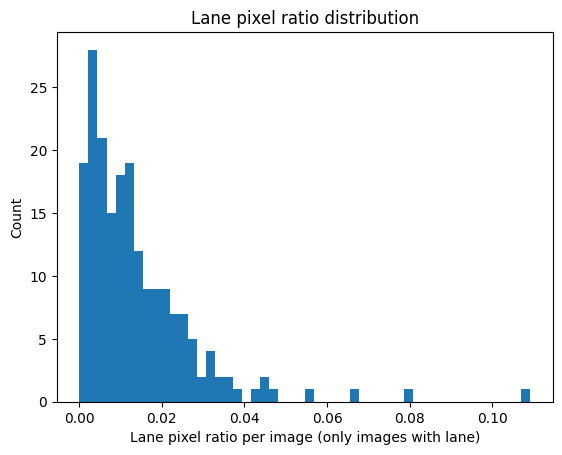

In [2]:
# =========================
# Distribution of Lane Mark Pixel Ratio per Image
# =========================
plt.figure()
plt.hist(df["lane_pixel_ratio"][df["lane_pixel_ratio"] > 0], bins=50)
plt.xlabel("Lane pixel ratio per image (only images with lane)")
plt.ylabel("Count")
plt.title("Lane pixel ratio distribution")
plt.show()

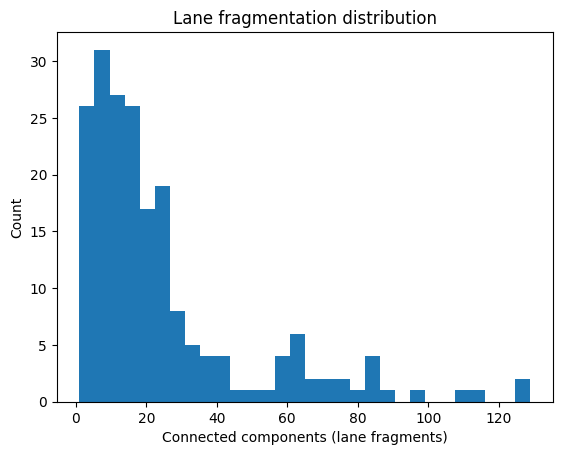

In [3]:
# =========================
# Distribution of Lane Mark Fragmentation per Image
# =========================
plt.figure()
plt.hist(df["components"][df["lane_pixels"] > 0], bins=30)
plt.xlabel("Connected components (lane fragments)")
plt.ylabel("Count")
plt.title("Lane fragmentation distribution")
plt.show()

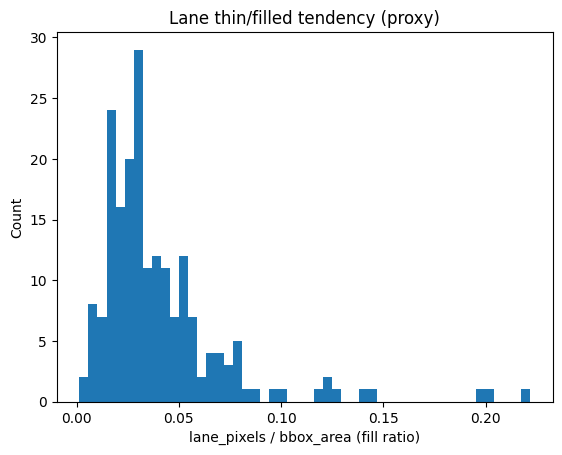

In [4]:
# =========================
# 레인 마크 두께 및 밀도 특성 분포
# =========================
plt.figure()
plt.hist(df["lane_fill_ratio"][df["lane_pixels"] > 0], bins=50)
plt.xlabel("lane_pixels / bbox_area (fill ratio)")
plt.ylabel("Count")
plt.title("Lane thin/filled tendency (proxy)")
plt.show()

#### 1 데이터의 핵심 특성 정리
 - has_lane_ratio = 0.985 (197/200) - lane이 없어서 학습이 안되는 것이 아님
 ##### lane_pixel_ratio_global => 1.37% (전체 픽셀 중 lane이 1.37%(평균), 중앙값 1.05%로 대부분 이미지에서 1% 내외로 얇게 존재
 - 모델이 lane을 작은 클래스로 보고 다른 클래스(Road)로 흡수하기 쉬운 조건
 - segformer가 전역 context 파악에 도움을 줄 수 있지만, loss/경계/해상도가 1차 관건임
 ##### lane mark 라벨은 조각(끊김)이 엄청 많음
 - components_mean => 24.5 (night ride(8).png는 components = 80임), small_comp_ration_mean = 0.465 (구성요소의 절반 가량이 작은 조각)
 ##### bbox 대비 픽셀 "채움비율"이 낮음 -> 길고 얇음
 - -> 라벨 박스 과대 lane_fill_ratio_media = 0.034 -> bbox 면적 대비 실제 lane 픽셀은 약 3%에 불과, 즉 긴 박스 안에 얇은 선 형태가 많음
##### 특징 정리
 - 경계/두께 복원이 중요(DeepLabV3+ 유리할 수 있음)

In [6]:
# =========================
# TOP-K 샘플 추출 (단서용)
# =========================
# 1) lane이 아주 희소한(학습 어려운) 이미지
display(df[df["lane_pixel_ratio"] > 0].sort_values("lane_pixel_ratio").head(10)[
    ["file_name","lane_ann_count","lane_pixels","lane_pixel_ratio","components","small_comp_ratio","lane_fill_ratio"]
])

# 2) lane이 매우 많은(대표 학습 샘플) 이미지
display(df.sort_values("lane_pixel_ratio", ascending=False).head(10)[
    ["file_name","lane_ann_count","lane_pixels","lane_pixel_ratio","components","small_comp_ratio","lane_fill_ratio"]
])

,file_name,lane_ann_count,lane_pixels,lane_pixel_ratio,components,small_comp_ratio,lane_fill_ratio
21,night ride (25).png,1,152,0.000073,6,1.000000,0.001364
37,night ride (37).png,1,219,0.000106,3,0.666667,0.034962
129,Screenshot (401).png,1,359,0.000173,1,0.000000,0.079425
43,night ride (58).png,1,743,0.000358,41,0.975610,0.005933
22,night ride (38).png,1,1265,0.000610,7,0.857143,0.030242
8,night ride (12).png,1,1542,0.000744,10,0.800000,0.013864
58,night ride (56).png,1,1725,0.000832,4,0.750000,0.039875
146,Screenshot (416).png,1,2011,0.000970,4,0.000000,0.003677
90,night ride (95).png,1,2232,0.001076,8,0.500000,0.016562
54,night ride (61).png,1,2443,0.001178,6,0.166667,0.010768


,file_name,lane_ann_count,lane_pixels,lane_pixel_ratio,components,small_comp_ratio,lane_fill_ratio
149,Screenshot (412).png,1,226383,0.109174,16,0.687500,0.195922
134,Screenshot (395).png,1,163759,0.078973,83,0.674699,0.200052
133,Screenshot (406).png,1,136726,0.065937,19,0.052632,0.142686
178,Screenshot (448).png,1,115942,0.055913,28,0.107143,0.097014
7,night ride (20).png,1,95791,0.046196,35,0.657143,0.079826
93,night ride (91).png,1,93409,0.045047,8,0.250000,0.078235
104,Screenshot (372).png,1,91817,0.044279,17,0.529412,0.057066
176,Screenshot (322).png,1,88770,0.042810,15,0.333333,0.056590
174,Screenshot (311).png,1,78388,0.037803,20,0.400000,0.062714
96,Screenshot (359).png,1,75359,0.036342,18,0.000000,0.083125


#### 2. 극단적인 케이스 정리
 ##### 차선 마크가 거의 없는 이미지
 -  lane_pixels = 152 (0.000073 = 0.0073%) 이런 이미지는 학습/평가에서 IoU를 깨뜨리는 킬러 샘플
 - 정답이 너무 작으면 조금만 틀려도 IoU가 0에 가까워짐

 ##### 반대로 차선 마크가 10% 이상인 이미지도 있음
- lane_pixel_ratio = 0.109 (약 10.9%)
- 분포가 넓어서 “모델이 어떤 두께/규모의 lane을 lane으로 볼지”가 학습 중 흔들릴 수 있음.
-  lane 스케일이 너무 넓고(희소~풍부), 조각이 많아서 단순 CE로는 안정적으로 못 잡는 구조                           

## Step 2: DeepLabV3+ Baseline 구축

In [14]:
# ============================================================
# DeepLabV3+ Baseline 
# Early Stopping (EPOCHS=30, PATIENCE=5)
# - COCO JSON(폴리곤) → semantic mask Dataset
# - DeepLabV3(ResNet50) head 교체
# - lane IoU 기준 best 저장 + Early Stopping
# - (옵션) W&B 로깅 + 고정 샘플 오버레이
# ============================================================

import os, time
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50

from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# -----------------------------
# (옵션) W&B
# -----------------------------
USE_WANDB = True
try:
    import wandb
except Exception as e:
    USE_WANDB = False
    print("[WARN] wandb import 실패 → W&B OFF:", e)

# -----------------------------
# 0) CONFIG
# -----------------------------
SEED = 42
EPOCHS = 30
PATIENCE = 5
MIN_DELTA = 1e-4  # 개선으로 인정할 최소 상승폭(너무 작으면 0.0으로)

LR = 1e-4
WEIGHT_DECAY = 3e-4
AMP = True

SIZE = (512, 512)
BATCH_SIZE = 4
NUM_WORKERS = 0  # Windows는 0 권장

PROJECT = "night_ride_seg"
RUN_NAME = "deeplabv3p_baseline_es"

DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ann_path  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

SAVE_DIR = os.path.join(DATA_ROOT, "checkpoints_deeplabv3p_es")
os.makedirs(SAVE_DIR, exist_ok=True)

# W&B notebook name 경고 제거(원하면 파일명으로 변경)
os.environ["WANDB_NOTEBOOK_NAME"] = "distil_segformer_deeplab.ipynb"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = (DEVICE == "cuda")

def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)
print("DEVICE:", DEVICE)
print("ann_path:", ann_path)

# -----------------------------
# 1) COCO 로드 + class mapping + split
# -----------------------------
coco = COCO(ann_path)

cat_ids = sorted(coco.getCatIds())
catid2name = {c["id"]: c["name"] for c in coco.cats.values()}

# 0=background, 1..K=각 category
id2train = {cid: i + 1 for i, cid in enumerate(cat_ids)}
train2name = {id2train[cid]: catid2name[cid] for cid in cat_ids}
NUM_CLASSES = max(id2train.values()) + 1

# Lane Mark 자동 식별 (name에 'lane' 포함)
lane_cat_ids = [cid for cid in cat_ids if "lane" in (catid2name[cid] or "").lower()]
if len(lane_cat_ids) != 1:
    print("[WARN] lane 카테고리 후보가 1개가 아닙니다:", lane_cat_ids, [catid2name[c] for c in lane_cat_ids])
LANE_CAT_ID = lane_cat_ids[0]
LANE_ID = id2train[LANE_CAT_ID]

print("NUM_CLASSES:", NUM_CLASSES)
print("LANE_CAT_ID:", LANE_CAT_ID, "| LANE_ID(train):", LANE_ID, "| name:", catid2name[LANE_CAT_ID])

# split (8:1:1)
img_ids = sorted(coco.imgs.keys())
np.random.seed(SEED)
np.random.shuffle(img_ids)

n = len(img_ids)
train_ids = img_ids[: int(0.8 * n)]
val_ids   = img_ids[int(0.8 * n): int(0.9 * n)]
test_ids  = img_ids[int(0.9 * n):]

print("split:", len(train_ids), len(val_ids), len(test_ids))

# -----------------------------
# 2) Dataset (COCO polygon -> semantic mask)
# -----------------------------
class COCOSemSeg(Dataset):
    def __init__(self, ann_path, img_dir, img_ids, id2train, size=(512,512),
                 train=True, transform_img=None, priority_order=None):
        self.coco = COCO(ann_path)
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.transform_img = transform_img

        self.catid2name = {c["id"]: c["name"] for c in self.coco.cats.values()}
        self._priority_map = None
        if priority_order:
            self._priority_map = {name: i for i, name in enumerate(priority_order)}

    def _ann_to_mask(self, anns, H, W):
        mask = np.zeros((H, W), dtype=np.int64)

        if self._priority_map is not None:
            anns = sorted(
                anns,
                key=lambda a: self._priority_map.get(self.catid2name[a["category_id"]], -1)
            )

        for a in anns:
            cat_id = a["category_id"]
            train_id = self.id2train.get(cat_id, 0)

            rle = self.coco.annToRLE(a)
            m = maskUtils.decode(rle).astype(bool)
            mask[m] = train_id

        return mask

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])
        img = Image.open(img_path).convert("RGB")

        H, W = info["height"], info["width"]
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        mask = self._ann_to_mask(anns, H, W)

        # resize
        img = img.resize(self.size, Image.BILINEAR)
        mask_pil = Image.fromarray(mask.astype(np.uint8)).resize(self.size, Image.NEAREST)
        mask = np.array(mask_pil, dtype=np.int64)

        if self.transform_img is not None:
            img = self.transform_img(img)

        return img, torch.from_numpy(mask)  # img: (3,H,W) float, mask: (H,W) long

transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

# "뒤에 올수록 덮어쓰기" (Lane를 보존하고 싶으면 Lane을 뒤로 배치)
priority_order = ["Undrivable", "Road", "Lane Mark", "Moveable", "My bike", "Rider"]

train_dataset = COCOSemSeg(ann_path, IMG_DIR, train_ids, id2train, size=SIZE,
                           train=True, transform_img=transform_img, priority_order=priority_order)
val_dataset   = COCOSemSeg(ann_path, IMG_DIR, val_ids, id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)
test_dataset  = COCOSemSeg(ann_path, IMG_DIR, test_ids, id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          drop_last=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          drop_last=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          drop_last=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

x0, y0 = next(iter(train_loader))
print("sanity x:", x0.shape, x0.dtype, "| y:", y0.shape, y0.dtype, "min/max:", int(y0.min()), int(y0.max()))

DEVICE: cuda
ann_path: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\COCO_motorcycle (pixel).json
loading annotations into memory...
Done (t=1.22s)
creating index...
index created!
NUM_CLASSES: 7
LANE_CAT_ID: 1323882 | LANE_ID(train): 3 | name: Lane Mark
split: 160 20 20
loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
loading annotations into memory...
Done (t=1.12s)
creating index...
index created!
sanity x: torch.Size([4, 3, 512, 512]) torch.float32 | y: torch.Size([4, 512, 512]) torch.int64 min/max: 0 6


In [16]:
# -----------------------------
# 3) Metrics (IoU)
# -----------------------------
@torch.no_grad()
def fast_confusion(pred: torch.Tensor, target: torch.Tensor, num_classes: int):
    pred = pred.view(-1)
    target = target.view(-1)
    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

@torch.no_grad()
def iou_from_conf(conf: torch.Tensor):
    conf = conf.float()
    tp = torch.diag(conf)
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = torch.where(denom > 0, tp / denom, torch.nan)
    miou = torch.nanmean(iou)
    return iou, miou

# -----------------------------
# 4) Model / Loss / Optim
# -----------------------------
model = deeplabv3_resnet50(weights="DEFAULT")
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(DEVICE)

# 최소 정칙화(불균형 완화): bg↓, lane↑
class_weights = torch.ones(NUM_CLASSES, device=DEVICE)
class_weights[0] = 0.3
class_weights[LANE_ID] = 6.0
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(AMP and DEVICE == "cuda"))

# -----------------------------
# 5) Fixed sample overlays (옵션)
# -----------------------------
def denorm(x, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    x = x.detach().cpu().clone()
    for c in range(3):
        x[c] = x[c]*std[c] + mean[c]
    x = torch.clamp(x, 0, 1)
    return x.permute(1,2,0).numpy()

def overlay_gray(img01, mask, alpha=0.35):
    m = mask.astype(np.float32)
    if m.max() > 0:
        m = m / m.max()
    m3 = np.stack([m,m,m], axis=-1)
    out = (1-alpha)*img01 + alpha*m3
    return np.clip(out, 0, 1)

@torch.no_grad()
def log_fixed_samples(max_items=4, step_name="val"):
    if not USE_WANDB:
        return
    model.eval()
    x, y = next(iter(val_loader))
    x = x.to(DEVICE)
    logits = model(x)["out"]
    pred = logits.argmax(1).cpu().numpy()
    y_np = y.numpy()

    imgs = []
    for i in range(min(max_items, x.size(0))):
        img01 = denorm(x[i])
        ov_gt = overlay_gray(img01, y_np[i])
        ov_pr = overlay_gray(img01, pred[i])
        imgs.append(wandb.Image(ov_gt, caption=f"{step_name} GT idx={i}"))
        imgs.append(wandb.Image(ov_pr, caption=f"{step_name} Pred idx={i}"))
    wandb.log({f"{step_name}/overlays": imgs})

# -----------------------------
# 6) Train / Eval
# -----------------------------
def train_one_epoch():
    model.train()
    total_loss = 0.0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.long)

    for x, y in train_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # FutureWarning 방지: torch.amp.autocast 사용
        with torch.amp.autocast(device_type="cuda", enabled=(AMP and DEVICE=="cuda")):
            logits = model(x)["out"]
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)

        pred = logits.argmax(1)
        conf += fast_confusion(pred.detach().cpu(), y.detach().cpu(), NUM_CLASSES)

    total_loss /= max(len(train_loader.dataset), 1)
    iou, miou = iou_from_conf(conf)
    lane_iou = float(iou[LANE_ID].item()) if not torch.isnan(iou[LANE_ID]) else float("nan")
    return total_loss, float(miou.item()), lane_iou, iou.cpu().numpy()

@torch.no_grad()
def eval_one_epoch():
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.long)

    for x, y in val_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        with torch.amp.autocast(device_type="cuda", enabled=(AMP and DEVICE=="cuda")):
            logits = model(x)["out"]
            loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)

        pred = logits.argmax(1)
        conf += fast_confusion(pred.detach().cpu(), y.detach().cpu(), NUM_CLASSES)

    total_loss /= max(len(val_loader.dataset), 1)
    iou, miou = iou_from_conf(conf)
    lane_iou = float(iou[LANE_ID].item()) if not torch.isnan(iou[LANE_ID]) else float("nan")
    return total_loss, float(miou.item()), lane_iou, iou.cpu().numpy()

C:\Users\hugctx\AppData\Local\Temp\ipykernel_32972\395195130.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(AMP and DEVICE == "cuda"))


In [18]:
# -----------------------------
# 7) W&B init
# -----------------------------
if USE_WANDB:
    wandb.init(
        project=PROJECT,
        name=RUN_NAME,
        config={
            "seed": SEED,
            "epochs": EPOCHS,
            "patience": PATIENCE,
            "min_delta": MIN_DELTA,
            "lr": LR,
            "weight_decay": WEIGHT_DECAY,
            "amp": AMP,
            "size": SIZE,
            "batch_size": BATCH_SIZE,
            "num_workers": NUM_WORKERS,
            "num_classes": NUM_CLASSES,
            "lane_id": LANE_ID,
            "priority_order": priority_order,
            "model": "deeplabv3_resnet50",
            "class_weights": class_weights.detach().cpu().tolist(),
        },
    )

# -----------------------------
# 8) Train + Early Stopping (val_lane_iou 기준)
# -----------------------------
best_lane_iou = -1.0
best_epoch = -1
best_path = None
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_miou, tr_lane_iou, _ = train_one_epoch()
    va_loss, va_miou, va_lane_iou, va_pc = eval_one_epoch()
    scheduler.step()

    lr_now = optimizer.param_groups[0]["lr"]
    sec = time.time() - t0

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train loss={tr_loss:.4f} miou={tr_miou:.4f} lane_iou={tr_lane_iou:.4f} | "
          f"val loss={va_loss:.4f} miou={va_miou:.4f} lane_iou={va_lane_iou:.4f} | "
          f"lr={lr_now:.2e} time={sec:.1f}s")

    if USE_WANDB:
        wandb.log({
            "epoch": epoch,
            "lr": lr_now,
            "train/loss": tr_loss,
            "train/miou": tr_miou,
            "train/lane_iou": tr_lane_iou,
            "val/loss": va_loss,
            "val/miou": va_miou,
            "val/lane_iou": va_lane_iou,
            "time/epoch_sec": sec,
        })

        # per-class IoU table (val)
        table = wandb.Table(
            data=[[i, train2name.get(i, "bg" if i==0 else f"class{i}"), float(va_pc[i])] for i in range(NUM_CLASSES)],
            columns=["class_id", "class_name", "val_iou"]
        )
        wandb.log({"val/per_class_iou": table})

        if epoch == 1 or epoch % 2 == 0:
            log_fixed_samples(max_items=4, step_name="val")

    # ----- best 저장 + early stopping 판단 -----
    improved = (np.isfinite(va_lane_iou) and (va_lane_iou > best_lane_iou + MIN_DELTA))
    if improved:
        best_lane_iou = va_lane_iou
        best_epoch = epoch
        no_improve = 0

        best_path = os.path.join(SAVE_DIR, f"best_deeplabv3p_laneiou_{best_lane_iou:.4f}.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "lane_iou": float(best_lane_iou),
            "num_classes": NUM_CLASSES,
            "lane_id": LANE_ID,
        }, best_path)
        print(f"  -> [BEST] epoch={epoch} lane_iou={best_lane_iou:.4f} saved: {best_path}")

        if USE_WANDB:
            wandb.log({"best/val_lane_iou": float(best_lane_iou), "best/epoch": best_epoch})
    else:
        no_improve += 1
        print(f"  -> no improvement: {no_improve}/{PATIENCE} (best {best_lane_iou:.4f} @epoch {best_epoch})")

    if no_improve >= PATIENCE:
        print(f"[EARLY STOP] epoch={epoch} (no improve for {PATIENCE} epochs). Best lane_iou={best_lane_iou:.4f} @epoch {best_epoch}")
        break

print("Done.")
print("Best val lane_iou:", float(best_lane_iou), "at epoch:", best_epoch)
print("Best ckpt:", best_path)

if USE_WANDB:
    wandb.finish()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find distil_segformer_deeplab.ipynb.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\hugctx\_netrc.
wandb: Currently logged in as: mastercoach-cha (mastercoach-cha-pawcheck) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[01/30] train loss=1.0607 miou=0.4593 lane_iou=0.0164 | val loss=0.5869 miou=0.5935 lane_iou=0.0079 | lr=9.97e-05 time=28.4s
  -> [BEST] epoch=1 lane_iou=0.0079 saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_deeplabv3p_es\best_deeplabv3p_laneiou_0.0079.pt
[02/30] train loss=0.5289 miou=0.6158 lane_iou=0.1218 | val loss=0.4328 miou=0.6528 lane_iou=0.2450 | lr=9.89e-05 time=26.6s
  -> [BEST] epoch=2 lane_iou=0.2450 saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_deeplabv3p_es\best_deeplabv3p_laneiou_0.2450.pt
[03/30] train loss=0.3854 miou=0.6565 lane_iou=0.2371 | val loss=0.3557 miou=0.6611 lane_iou=0.2604 | lr=9.76e-05 time=27.4s
  -> [BEST] epoch=3 lane_iou=0.2604 saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_deeplabv3p_es\best_deeplabv3p_lane

best/epoch,▁▂▂▃▄▅▅▆█
best/val_lane_iou,▁▅▅▆▇▇▇██
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
lr,████▇▇▇▆▆▅▅▄▄▃▃▂▂▁
time/epoch_sec,▅▁▃▆███▃▇▁▂▃▃▃▂▃▃▄
train/lane_iou,▁▂▄▅▆▆▆▇▇▇▇▇██████
train/loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/miou,▁▅▆▆▇▇▇▇▇█████████
val/lane_iou,▁▅▅▆▆▇▇▇██████████
val/loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


## 요약
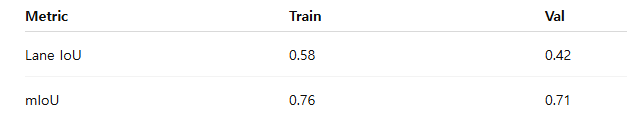

## Step 3. SegFormer 베이스라인 구축

In [19]:
# ============================================================
# Step 3: SegFormer Baseline (From Scratch) 
#  Early Stopping
# DeepLab v3 + 와 기준 EPOCHS=30, PATIENCE=5, val_lane_iou 기준 best 저장 + early stop
# - COCO JSON(폴리곤) → semantic mask Dataset
# - SegFormer(MiT backbone) fine-tuning (HuggingFace Transformers)
# - W&B 로깅 + 고정 샘플 오버레이(매 2epoch)
# 사전 준비:
#   pip install -U transformers accelerate
# ============================================================

import os, time
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# -----------------------------
# transformers (SegFormer)
# -----------------------------
try:
    from transformers import SegformerForSemanticSegmentation
except Exception as e:
    raise RuntimeError(
        "SegFormer 사용을 위해 transformers가 필요합니다.\n"
        "설치: pip install -U transformers accelerate\n"
        f"원인: {e}"
    )

# -----------------------------
# (옵션) W&B
# -----------------------------
USE_WANDB = True
try:
    import wandb
except Exception as e:
    USE_WANDB = False
    print("[WARN] wandb import 실패 → W&B OFF:", e)

# -----------------------------
# 0) CONFIG (DeepLab과 동일 기준)
# -----------------------------
SEED = 42
EPOCHS = 30
PATIENCE = 5
MIN_DELTA = 1e-4

LR = 6e-5               # SegFormer는 보통 3e-5~1e-4 사이
WEIGHT_DECAY = 1e-2     # transformer류는 1e-2가 흔함 (baseline은 0.01 추천)
AMP = True

SIZE = (512, 512)
BATCH_SIZE = 4
NUM_WORKERS = 0  # Windows 0 권장

PROJECT = "night_ride_seg"
RUN_NAME = "segformer_baseline_es"

# SegFormer backbone 선택:
# - b0: 가볍고 빠름(teacher로는 약할 수 있음)
# - b2: 무난한 teacher 후보
# - b3: 더 강함(속도/메모리 부담↑)
SEGFORMER_MODEL_NAME = "nvidia/segformer-b2-finetuned-ade-512-512"

DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ann_path  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

SAVE_DIR = os.path.join(DATA_ROOT, "checkpoints_segformer_es")
os.makedirs(SAVE_DIR, exist_ok=True)

os.environ["WANDB_NOTEBOOK_NAME"] = "distil_segformer_deeplab.ipynb"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = (DEVICE == "cuda")

def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)
print("DEVICE:", DEVICE)
print("ann_path:", ann_path)
print("SEGFORMER_MODEL_NAME:", SEGFORMER_MODEL_NAME)

# -----------------------------
# 1) COCO 로드 + class mapping + split
# -----------------------------
coco = COCO(ann_path)

cat_ids = sorted(coco.getCatIds())
catid2name = {c["id"]: c["name"] for c in coco.cats.values()}

id2train = {cid: i + 1 for i, cid in enumerate(cat_ids)}  # 0=bg
train2name = {id2train[cid]: catid2name[cid] for cid in cat_ids}
NUM_CLASSES = max(id2train.values()) + 1

lane_cat_ids = [cid for cid in cat_ids if "lane" in (catid2name[cid] or "").lower()]
if len(lane_cat_ids) != 1:
    print("[WARN] lane 카테고리 후보가 1개가 아닙니다:", lane_cat_ids, [catid2name[c] for c in lane_cat_ids])
LANE_CAT_ID = lane_cat_ids[0]
LANE_ID = id2train[LANE_CAT_ID]

print("NUM_CLASSES:", NUM_CLASSES)
print("LANE_CAT_ID:", LANE_CAT_ID, "| LANE_ID(train):", LANE_ID, "| name:", catid2name[LANE_CAT_ID])

img_ids = sorted(coco.imgs.keys())
np.random.seed(SEED)
np.random.shuffle(img_ids)

n = len(img_ids)
train_ids = img_ids[: int(0.8 * n)]
val_ids   = img_ids[int(0.8 * n): int(0.9 * n)]
test_ids  = img_ids[int(0.9 * n):]
print("split:", len(train_ids), len(val_ids), len(test_ids))

# -----------------------------
# 2) Dataset (COCO polygon -> semantic mask)
# -----------------------------
class COCOSemSeg(Dataset):
    def __init__(self, ann_path, img_dir, img_ids, id2train, size=(512,512),
                 train=True, transform_img=None, priority_order=None):
        self.coco = COCO(ann_path)
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.transform_img = transform_img

        self.catid2name = {c["id"]: c["name"] for c in self.coco.cats.values()}
        self._priority_map = None
        if priority_order:
            self._priority_map = {name: i for i, name in enumerate(priority_order)}

    def _ann_to_mask(self, anns, H, W):
        mask = np.zeros((H, W), dtype=np.int64)

        if self._priority_map is not None:
            anns = sorted(
                anns,
                key=lambda a: self._priority_map.get(self.catid2name[a["category_id"]], -1)
            )

        for a in anns:
            cat_id = a["category_id"]
            train_id = self.id2train.get(cat_id, 0)

            rle = self.coco.annToRLE(a)
            m = maskUtils.decode(rle).astype(bool)
            mask[m] = train_id

        return mask

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])
        img = Image.open(img_path).convert("RGB")

        H, W = info["height"], info["width"]
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        mask = self._ann_to_mask(anns, H, W)

        # resize (img bilinear / mask nearest)
        img = img.resize(self.size, Image.BILINEAR)
        mask_pil = Image.fromarray(mask.astype(np.uint8)).resize(self.size, Image.NEAREST)
        mask = np.array(mask_pil, dtype=np.int64)

        if self.transform_img is not None:
            img = self.transform_img(img)  # (3,H,W) normalized tensor

        return img, torch.from_numpy(mask)

transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

priority_order = ["Undrivable", "Road", "Lane Mark", "Moveable", "My bike", "Rider"]

train_dataset = COCOSemSeg(ann_path, IMG_DIR, train_ids, id2train, size=SIZE,
                           train=True, transform_img=transform_img, priority_order=priority_order)
val_dataset   = COCOSemSeg(ann_path, IMG_DIR, val_ids, id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)
test_dataset  = COCOSemSeg(ann_path, IMG_DIR, test_ids, id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          drop_last=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          drop_last=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          drop_last=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

x0, y0 = next(iter(train_loader))
print("sanity x:", x0.shape, x0.dtype, "| y:", y0.shape, y0.dtype, "min/max:", int(y0.min()), int(y0.max()))

DEVICE: cuda
ann_path: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\COCO_motorcycle (pixel).json
SEGFORMER_MODEL_NAME: nvidia/segformer-b2-finetuned-ade-512-512
loading annotations into memory...
Done (t=1.63s)
creating index...
index created!
NUM_CLASSES: 7
LANE_CAT_ID: 1323882 | LANE_ID(train): 3 | name: Lane Mark
split: 160 20 20
loading annotations into memory...
Done (t=1.21s)
creating index...
index created!
loading annotations into memory...
Done (t=1.21s)
creating index...
index created!
loading annotations into memory...
Done (t=1.17s)
creating index...
index created!
sanity x: torch.Size([4, 3, 512, 512]) torch.float32 | y: torch.Size([4, 512, 512]) torch.int64 min/max: 0 6


In [46]:
# -----------------------------
# 3) Metrics (IoU)
# -----------------------------
@torch.no_grad()
def fast_confusion(pred: torch.Tensor, target: torch.Tensor, num_classes: int):
    pred = pred.view(-1)
    target = target.view(-1)
    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

@torch.no_grad()
def iou_from_conf(conf: torch.Tensor):
    conf = conf.float()
    tp = torch.diag(conf)
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = torch.where(denom > 0, tp / denom, torch.nan)
    miou = torch.nanmean(iou)
    return iou, miou

# -----------------------------
# 4) SegFormer Model
# -----------------------------
# label mappings (HuggingFace config에 반영)
id2label = {i: ("background" if i == 0 else train2name.get(i, f"class{i}")) for i in range(NUM_CLASSES)}
label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    SEGFORMER_MODEL_NAME,
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 헤드 크기 다르면 자동 초기화
)
model.to(DEVICE)

# -----------------------------
# 5) Loss / Optim
# -----------------------------
# SegFormer는 forward에 labels 넣으면 내부 CE를 계산하지만,
# "lane 가중치"를 주려면 우리가 직접 loss를 계산해야 함.
class_weights = torch.ones(NUM_CLASSES, device=DEVICE)
class_weights[0] = 0.3
class_weights[LANE_ID] = 6.0
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(AMP and DEVICE == "cuda"))

# -----------------------------
# 6) Overlays (옵션)
# -----------------------------
def denorm(x, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    x = x.detach().cpu().clone()
    for c in range(3):
        x[c] = x[c]*std[c] + mean[c]
    x = torch.clamp(x, 0, 1)
    return x.permute(1,2,0).numpy()

def overlay_gray(img01, mask, alpha=0.35):
    m = mask.astype(np.float32)
    if m.max() > 0:
        m = m / m.max()
    m3 = np.stack([m,m,m], axis=-1)
    out = (1-alpha)*img01 + alpha*m3
    return np.clip(out, 0, 1)

@torch.no_grad()
def log_fixed_samples(max_items=4, step_name="val"):
    if not USE_WANDB:
        return
    model.eval()
    x, y = next(iter(val_loader))
    x = x.to(DEVICE)

    out = model(pixel_values=x)  # logits: (B,C,h,w)
    logits = out.logits
    # SegFormer logits는 입력보다 작을 수 있음 → upsample
    logits_up = torch.nn.functional.interpolate(
        logits, size=SIZE, mode="bilinear", align_corners=False
    )
    pred = logits_up.argmax(1).cpu().numpy()
    y_np = y.numpy()

    imgs = []
    for i in range(min(max_items, x.size(0))):
        img01 = denorm(x[i])
        ov_gt = overlay_gray(img01, y_np[i])
        ov_pr = overlay_gray(img01, pred[i])
        imgs.append(wandb.Image(ov_gt, caption=f"{step_name} GT idx={i}"))
        imgs.append(wandb.Image(ov_pr, caption=f"{step_name} Pred idx={i}"))
    wandb.log({f"{step_name}/overlays": imgs})

# -----------------------------
# 7) Train / Eval
# -----------------------------
def train_one_epoch():
    model.train()
    total_loss = 0.0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.long)

    for x, y in train_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda", enabled=(AMP and DEVICE=="cuda")):
            out = model(pixel_values=x)     # logits: (B,C,h,w)
            logits = out.logits
            logits_up = torch.nn.functional.interpolate(
                logits, size=SIZE, mode="bilinear", align_corners=False
            )
            loss = criterion(logits_up, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)

        pred = logits_up.argmax(1)
        conf += fast_confusion(pred.detach().cpu(), y.detach().cpu(), NUM_CLASSES)

    total_loss /= max(len(train_loader.dataset), 1)
    iou, miou = iou_from_conf(conf)
    lane_iou = float(iou[LANE_ID].item()) if not torch.isnan(iou[LANE_ID]) else float("nan")
    return total_loss, float(miou.item()), lane_iou, iou.cpu().numpy()

@torch.no_grad()
def eval_one_epoch():
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.long)

    for x, y in val_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        with torch.amp.autocast(device_type="cuda", enabled=(AMP and DEVICE=="cuda")):
            out = model(pixel_values=x)
            logits = out.logits
            logits_up = torch.nn.functional.interpolate(
                logits, size=SIZE, mode="bilinear", align_corners=False
            )
            loss = criterion(logits_up, y)

        total_loss += loss.item() * x.size(0)

        pred = logits_up.argmax(1)
        conf += fast_confusion(pred.detach().cpu(), y.detach().cpu(), NUM_CLASSES)

    total_loss /= max(len(val_loader.dataset), 1)
    iou, miou = iou_from_conf(conf)
    lane_iou = float(iou[LANE_ID].item()) if not torch.isnan(iou[LANE_ID]) else float("nan")
    return total_loss, float(miou.item()), lane_iou, iou.cpu().numpy()



Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([7, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hugctx\AppData\Local\Temp\ipykernel_32972\3141346214.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(AMP and DEVICE == "cuda"))


In [21]:
# -----------------------------
# 8) W&B init
# -----------------------------
if USE_WANDB:
    wandb.init(
        project=PROJECT,
        name=RUN_NAME,
        config={
            "seed": SEED,
            "epochs": EPOCHS,
            "patience": PATIENCE,
            "min_delta": MIN_DELTA,
            "lr": LR,
            "weight_decay": WEIGHT_DECAY,
            "amp": AMP,
            "size": SIZE,
            "batch_size": BATCH_SIZE,
            "num_workers": NUM_WORKERS,
            "num_classes": NUM_CLASSES,
            "lane_id": LANE_ID,
            "priority_order": priority_order,
            "model": SEGFORMER_MODEL_NAME,
            "class_weights": class_weights.detach().cpu().tolist(),
        },
    )

# -----------------------------
# 9) Train + Early Stopping (val_lane_iou 기준)
# -----------------------------
best_lane_iou = -1.0
best_epoch = -1
best_path = None
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_miou, tr_lane_iou, _ = train_one_epoch()
    va_loss, va_miou, va_lane_iou, va_pc = eval_one_epoch()
    scheduler.step()

    lr_now = optimizer.param_groups[0]["lr"]
    sec = time.time() - t0

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train loss={tr_loss:.4f} miou={tr_miou:.4f} lane_iou={tr_lane_iou:.4f} | "
          f"val loss={va_loss:.4f} miou={va_miou:.4f} lane_iou={va_lane_iou:.4f} | "
          f"lr={lr_now:.2e} time={sec:.1f}s")

    if USE_WANDB:
        wandb.log({
            "epoch": epoch,
            "lr": lr_now,
            "train/loss": tr_loss,
            "train/miou": tr_miou,
            "train/lane_iou": tr_lane_iou,
            "val/loss": va_loss,
            "val/miou": va_miou,
            "val/lane_iou": va_lane_iou,
            "time/epoch_sec": sec,
        })

        # per-class IoU table (val)
        table = wandb.Table(
            data=[[i, id2label.get(i, f"class{i}"), float(va_pc[i])] for i in range(NUM_CLASSES)],
            columns=["class_id", "class_name", "val_iou"]
        )
        wandb.log({"val/per_class_iou": table})

        if epoch == 1 or epoch % 2 == 0:
            log_fixed_samples(max_items=4, step_name="val")

    improved = (np.isfinite(va_lane_iou) and (va_lane_iou > best_lane_iou + MIN_DELTA))
    if improved:
        best_lane_iou = va_lane_iou
        best_epoch = epoch
        no_improve = 0

        best_path = os.path.join(SAVE_DIR, f"best_segformer_laneiou_{best_lane_iou:.4f}.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "lane_iou": float(best_lane_iou),
            "num_classes": NUM_CLASSES,
            "lane_id": LANE_ID,
            "segformer_model_name": SEGFORMER_MODEL_NAME,
        }, best_path)
        print(f"  -> [BEST] epoch={epoch} lane_iou={best_lane_iou:.4f} saved: {best_path}")

        if USE_WANDB:
            wandb.log({"best/val_lane_iou": float(best_lane_iou), "best/epoch": best_epoch})
    else:
        no_improve += 1
        print(f"  -> no improvement: {no_improve}/{PATIENCE} (best {best_lane_iou:.4f} @epoch {best_epoch})")

    if no_improve >= PATIENCE:
        print(f"[EARLY STOP] epoch={epoch} (no improve for {PATIENCE} epochs). Best lane_iou={best_lane_iou:.4f} @epoch {best_epoch}")
        break

print("Done.")
print("Best val lane_iou:", float(best_lane_iou), "at epoch:", best_epoch)
print("Best ckpt:", best_path)

if USE_WANDB:
    wandb.finish()


[01/30] train loss=1.3686 miou=0.3188 lane_iou=0.0181 | val loss=0.8768 miou=0.4455 lane_iou=0.0025 | lr=5.98e-05 time=29.9s
  -> [BEST] epoch=1 lane_iou=0.0025 saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_segformer_es\best_segformer_laneiou_0.0025.pt
[02/30] train loss=0.7567 miou=0.5007 lane_iou=0.0029 | val loss=0.5744 miou=0.5593 lane_iou=0.0025 | lr=5.93e-05 time=28.4s
  -> no improvement: 1/5 (best 0.0025 @epoch 1)
[03/30] train loss=0.5251 miou=0.5806 lane_iou=0.0787 | val loss=0.4347 miou=0.6298 lane_iou=0.2672 | lr=5.85e-05 time=27.8s
  -> [BEST] epoch=3 lane_iou=0.2672 saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_segformer_es\best_segformer_laneiou_0.2672.pt
[04/30] train loss=0.4068 miou=0.6310 lane_iou=0.2548 | val loss=0.3492 miou=0.6525 lane_iou=0.3577 | lr=5.74e-05 time=28.3s
  -> [BEST] epoch=4 lane_iou=0

best/epoch,▁▂▂▃▅▅▆▆▇██
best/val_lane_iou,▁▅▆▇▇▇▇████
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
lr,█████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
time/epoch_sec,█▃▁▃▁▃▄▃▃▃▂▃▃▃▄▅▇█▅▆▅▇▅▂
train/lane_iou,▁▁▂▄▅▅▆▆▆▇▇▇▇▇▇█████████
train/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/miou,▁▄▅▆▇▇▇▇▇▇▇█████████████
val/lane_iou,▁▁▅▆▆▇▆▇▇▇▇▇▇▇██████████
val/loss,█▅▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


## Step 4. W&B 성능비교

In [22]:
# =========================
# Step 4. W&B 성능 비교 (ONE CELL)
# - DeepLabV3+ run vs SegFormer run
# - lane_iou / miou / loss / lr / epoch_time 비교
# - best epoch, best lane_iou 요약 테이블
# - 인사이트: 승자/격차/역전 시점/격차 Top-K/초반 개선속도/오버핏 힌트
# =========================

# =========================
# Step 4. W&B 성능 비교 (ONE CELL) - 출력 섹션 헤더 강화 버전
# =========================
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 출력 유틸(섹션 헤더)
# -------------------------
def section(title: str, idx: int = None, char: str = "=", width: int = 60):
    head = f"[{idx}] {title}" if idx is not None else title
    print("\n" + char * width)
    print(head)
    print(char * width)

def bullet(msg: str):
    print(f"- {msg}")

# ---- 1) RUN URL 입력 ----
RUN_URL_DEEPLAB = "https://wandb.ai/mastercoach-cha-pawcheck/night_ride_seg/runs/4298gi8q"
RUN_URL_SEGF    = "https://wandb.ai/mastercoach-cha-pawcheck/night_ride_seg/runs/8q9ag7ol"

# ---- 2) URL -> entity/project/run_id 파싱 ----
def parse_run_url(url: str):
    # https://wandb.ai/<entity>/<project>/runs/<run_id>
    parts = url.strip("/").split("/")
    run_id = parts[-1]
    project = parts[-3]
    entity = parts[-4]
    return entity, project, run_id

entity1, project1, runid1 = parse_run_url(RUN_URL_DEEPLAB)
entity2, project2, runid2 = parse_run_url(RUN_URL_SEGF)
assert (entity1, project1) == (entity2, project2), "두 run은 같은 entity/project여야 합니다."

ENTITY, PROJECT = entity1, project1
api = wandb.Api()

# ---- 3) run history 가져오기 ----
def fetch_history(run):
    hist = run.history(samples=10000)
    hist = hist.replace([np.inf, -np.inf], np.nan)
    return hist

run_deeplab = api.run(f"{ENTITY}/{PROJECT}/{runid1}")
run_segform = api.run(f"{ENTITY}/{PROJECT}/{runid2}")

hist_d = fetch_history(run_deeplab)
hist_s = fetch_history(run_segform)

# ---- 4) 비교에 쓸 컬럼 자동 탐색 ----
CAND_KEYS = [
    "epoch",
    "lr",
    "time/epoch_sec",
    "train/loss", "val/loss",
    "train/miou", "val/miou",
    "train/lane_iou", "val/lane_iou",
    "best/val_lane_iou", "best/epoch",
]

def pick_cols(df, keys):
    cols = [k for k in keys if k in df.columns]
    return df[cols].copy()

d = pick_cols(hist_d, CAND_KEYS)
s = pick_cols(hist_s, CAND_KEYS)

# epoch 없으면 보험 처리
if "epoch" not in d.columns:
    d["epoch"] = np.arange(1, len(d) + 1)
if "epoch" not in s.columns:
    s["epoch"] = np.arange(1, len(s) + 1)

# ---- 5) best lane_iou / epoch 계산 ----
def get_best(df):
    if "val/lane_iou" in df.columns and df["val/lane_iou"].notna().any():
        idx = df["val/lane_iou"].astype(float).idxmax()
        best_epoch = int(df.loc[idx, "epoch"])
        best_lane = float(df.loc[idx, "val/lane_iou"])
        return best_epoch, best_lane
    return None, None

best_epoch_d, best_lane_d = get_best(d)
best_epoch_s, best_lane_s = get_best(s)

# ---- 6) run 메타/요약 테이블 ----
def run_summary(run, df, best_epoch, best_lane):
    last_epoch = int(df["epoch"].dropna().iloc[-1]) if len(df) else None
    def last_of(key):
        if key in df.columns and df[key].notna().any():
            return float(df[key].dropna().iloc[-1])
        return None

    return {
        "run_name": run.name,
        "run_id": run.id,
        "model_tag": run.config.get("model", ""),
        "epochs_ran": last_epoch,
        "best_epoch(val_lane)": best_epoch,
        "best_val_lane_iou": best_lane,
        "last_val_lane_iou": last_of("val/lane_iou"),
        "last_val_miou": last_of("val/miou"),
        "last_val_loss": last_of("val/loss"),
    }

section("Run 요약 테이블", idx=1)
summary_df = pd.DataFrame([
    run_summary(run_deeplab, d, best_epoch_d, best_lane_d),
    run_summary(run_segform, s, best_epoch_s, best_lane_s),
])
display(summary_df)

# ---- (선택) 그래프는 원하시면 다시 붙이세요. 여기서는 출력 섹션만 개선 요청이라 생략 가능 ----
# def plot_compare(...): ...

# ---- 7) 인사이트 출력 ----
def safe_last(df, key):
    if key in df.columns and df[key].notna().any():
        return float(df[key].dropna().iloc[-1])
    return None

last_lane_d = safe_last(d, "val/lane_iou")
last_lane_s = safe_last(s, "val/lane_iou")
last_miou_d = safe_last(d, "val/miou")
last_miou_s = safe_last(s, "val/miou")
last_loss_d = safe_last(d, "val/loss")
last_loss_s = safe_last(s, "val/loss")

section("Step 4 인사이트 요약", idx=2)
if best_lane_d is not None and best_lane_s is not None:
    diff_best = best_lane_s - best_lane_d
    winner = "SegFormer" if diff_best > 0 else "DeepLabV3+"
    bullet(f"Best Val Lane IoU: SegFormer={best_lane_s:.6f} (ep{best_epoch_s}) vs DeepLabV3+={best_lane_d:.6f} (ep{best_epoch_d})")
    bullet(f"Winner(best): {winner} | Δ(best)={diff_best:+.6f}")
else:
    bullet("Best Val Lane IoU를 계산할 수 없습니다. (val/lane_iou 로그가 없거나 비어있음)")

if last_lane_d is not None and last_lane_s is not None:
    diff_last = last_lane_s - last_lane_d
    winner_last = "SegFormer" if diff_last > 0 else "DeepLabV3+"
    bullet(f"Last Val Lane IoU: SegFormer={last_lane_s:.6f} vs DeepLabV3+={last_lane_d:.6f}")
    bullet(f"Winner(last): {winner_last} | Δ(last)={diff_last:+.6f}")

if last_miou_d is not None and last_miou_s is not None:
    bullet(f"Last Val mIoU: SegFormer={last_miou_s:.6f} vs DeepLabV3+={last_miou_d:.6f} | Δ={last_miou_s-last_miou_d:+.6f}")

if last_loss_d is not None and last_loss_s is not None:
    bullet(f"Last Val Loss: SegFormer={last_loss_s:.6f} vs DeepLabV3+={last_loss_d:.6f} | Δ={last_loss_s-last_loss_d:+.6f}")

# ---- 8) 역전 시점 + 격차 Top-K ----
section("SegFormer가 언제부터 앞섰나? + Lane IoU 격차 Top-K", idx=3)
if "val/lane_iou" in d.columns and "val/lane_iou" in s.columns:
    dd = d[["epoch","val/lane_iou"]].dropna().copy()
    ss = s[["epoch","val/lane_iou"]].dropna().copy()
    merged = dd.merge(ss, on="epoch", suffixes=("_deeplab","_segformer"))
    merged["seg_minus_dee"] = merged["val/lane_iou_segformer"] - merged["val/lane_iou_deeplab"]

    lead_epochs = merged[merged["seg_minus_dee"] > 0]
    if len(lead_epochs) > 0:
        first_lead = int(lead_epochs.iloc[0]["epoch"])
        bullet(f"첫 역전 epoch (val/lane_iou 기준): {first_lead}")
    else:
        bullet("역전 epoch가 없습니다. (또는 epoch merge 불일치)")

    bullet("격차 Top-10 (SegFormer - DeepLabV3+):")
    top_gap = merged.sort_values("seg_minus_dee", ascending=False).head(10)
    display(top_gap[["epoch","val/lane_iou_deeplab","val/lane_iou_segformer","seg_minus_dee"]])
else:
    bullet("val/lane_iou 로그가 둘 중 하나에 없습니다.")

# ---- 9) 오버핏 힌트 ----
section("오버핏 힌트: (train_lane - val_lane) GAP", idx=4)
if "train/lane_iou" in d.columns and "val/lane_iou" in d.columns:
    d_gap = (d["train/lane_iou"] - d["val/lane_iou"]).dropna()
    if len(d_gap) > 0:
        bullet(f"DeepLabV3+ gap: last={float(d_gap.iloc[-1]):+.4f}, max={float(d_gap.max()):+.4f}")
    else:
        bullet("DeepLabV3+ gap 계산 불가(값 부족).")
else:
    bullet("DeepLabV3+에 train/lane_iou 또는 val/lane_iou 로그가 없습니다.")

if "train/lane_iou" in s.columns and "val/lane_iou" in s.columns:
    s_gap = (s["train/lane_iou"] - s["val/lane_iou"]).dropna()
    if len(s_gap) > 0:
        bullet(f"SegFormer gap: last={float(s_gap.iloc[-1]):+.4f}, max={float(s_gap.max()):+.4f}")
    else:
        bullet("SegFormer gap 계산 불가(값 부족).")
else:
    bullet("SegFormer에 train/lane_iou 또는 val/lane_iou 로그가 없습니다.")



[1] Run 요약 테이블


,run_name,run_id,model_tag,epochs_ran,best_epoch(val_lane),best_val_lane_iou,last_val_lane_iou,last_val_miou,last_val_loss
0,deeplabv3p_baseline_es,4298gi8q,deeplabv3_resnet50,25,20,0.449633,0.425555,0.708753,0.229707
1,segformer_baseline_es,8q9ag7ol,nvidia/segformer-b2-finetuned-ade-512-512,24,19,0.473298,0.460879,0.697998,0.215693



[2] Step 4 인사이트 요약
- Best Val Lane IoU: SegFormer=0.473298 (ep19) vs DeepLabV3+=0.449633 (ep20)
- Winner(best): SegFormer | Δ(best)=+0.023665
- Last Val Lane IoU: SegFormer=0.460879 vs DeepLabV3+=0.425555
- Winner(last): SegFormer | Δ(last)=+0.035324
- Last Val mIoU: SegFormer=0.697998 vs DeepLabV3+=0.708753 | Δ=-0.010755
- Last Val Loss: SegFormer=0.215693 vs DeepLabV3+=0.229707 | Δ=-0.014013

[3] SegFormer가 언제부터 앞섰나? + Lane IoU 격차 Top-K
- 첫 역전 epoch (val/lane_iou 기준): 3
- 격차 Top-10 (SegFormer - DeepLabV3+):


,epoch,val/lane_iou_deeplab,val/lane_iou_segformer,seg_minus_dee
18,19.0,0.419997,0.473298,0.053301
5,6.0,0.362129,0.404851,0.042722
22,23.0,0.433159,0.472799,0.039640
15,16.0,0.419529,0.454943,0.035414
17,18.0,0.427885,0.460583,0.032698
3,4.0,0.326223,0.357752,0.031529
21,22.0,0.430391,0.461487,0.031096
23,24.0,0.431664,0.460879,0.029215
16,17.0,0.427366,0.450742,0.023376
10,11.0,0.404139,0.426782,0.022643



[4] 오버핏 힌트: (train_lane - val_lane) GAP
- DeepLabV3+ gap: last=+0.1554, max=+0.1554
- SegFormer gap: last=+0.0780, max=+0.0814


### 지식 증류 실험 조건 판정(달성)
- SegFormer는 실험 결과에서 lane IoU가 0.473으로 DeepLabV3+(0.449)보다 높아 더 정확한 예측 능력을 보였으므로 Teacher 모델로 적합
- 반면 DeepLabV3+는 구조가 비교적 단순하고 가벼워 추론 속도와 안정성이 뛰어나 실서비스 적용에 유리함. 
- 따라서 SegFormer의 높은 표현력과 패턴 인식 능력을 지식 증류로 DeepLabV3+에 전달하여, 성능과 효율성을 동시에 확보하려고 함.

## Step 5. 오판정 샘플 자동추출

In [23]:
# =========================
# Step 5. 오판정 샘플 자동추출 (ONE CELL)
# - GT(COCO) vs Pred(모델) 비교
# - lane IoU 낮은 Top-K / FN 많은 Top-K / FP 많은 Top-K 추출
# - 결과 CSV 저장 + (옵션) 오버레이 이미지 저장
# =========================

import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# -------------------------
# CONFIG
# -------------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR  = os.path.join(DATA_ROOT, "images")
ann_path = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

# ★ 매우 중요: "train id 기준 lane 클래스"
LANE_ID = 3   # <= (추정) Lane Mark가 id2train에서 3이었던 케이스. 필요시 수정.

# 모델/디바이스
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 입력 크기: 학습 때 쓴 SIZE와 동일하게
SIZE = (512, 512)  # (H,W)

# 모델 선택: 아래 둘 중 하나만 True로
USE_DEEPLAB = True
USE_SEGF    = False

# DeepLab 체크포인트(본인 경로로 수정)
DEEPLAB_CKPT = os.path.join(DATA_ROOT, "checkpoints_deeplabv3p_es", "best_deeplabv3p_laneiou_0.4496.pt")

# SegFormer 체크포인트(본인 경로로 수정)
SEGF_CKPT = os.path.join(DATA_ROOT, "checkpoints_segformer_es", "best_segformer_laneiou_0.4733.pt")

# 추출 개수
TOPK = 30

# 결과 저장
OUT_DIR = os.path.join(DATA_ROOT, "misclassified_samples")
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CSV = os.path.join(OUT_DIR, "misclassified_topk.csv")

# 오버레이 저장(많이 저장하면 느려짐)
SAVE_OVERLAY = True
OVERLAY_DIR = os.path.join(OUT_DIR, "overlay")
os.makedirs(OVERLAY_DIR, exist_ok=True)

# -------------------------
# 0) COCO 로드
# -------------------------
coco = COCO(ann_path)

# -------------------------
# 1) id2train 자동 추정(가능하면)
#  - 사용자가 이미 id2train dict를 따로 만들었으면 그걸 쓰면 됨
#  - 여기서는 "lane_cat_ids = name에 lane 포함"을 기준으로 cat id를 찾고,
#    사용자가 알려준 {catid: trainid} 매핑이 있으면 그걸 사용해야 가장 정확함.
# -------------------------
# 여기서는 그냥 catid2name을 찍어두고, GT 마스크는 "lane 관련 cat id들"로 union
catid2name = {c["id"]: c["name"] for c in coco.cats.values()}
lane_cat_ids = [cid for cid, name in catid2name.items() if "lane" in (name or "").lower()]
print("lane_cat_ids:", lane_cat_ids, "| names:", [catid2name[c] for c in lane_cat_ids])

# -------------------------
# 2) GT lane mask 만들기 함수
# -------------------------
def load_gt_lane_mask(img_id: int):
    info = coco.loadImgs(img_id)[0]
    H, W = info["height"], info["width"]
    ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=lane_cat_ids)
    anns = coco.loadAnns(ann_ids)
    if len(anns) == 0:
        return info, np.zeros((H, W), dtype=np.uint8)

    union = np.zeros((H, W), dtype=np.uint8)
    for a in anns:
        rle = coco.annToRLE(a)
        m = maskUtils.decode(rle).astype(np.uint8)
        union = np.maximum(union, m)
    return info, union  # (H,W) 0/1

# -------------------------
# 3) 모델 로드 + 예측 함수
# -------------------------
# 공통 전처리(학습 때 normalize 썼다면 동일하게 맞추세요)
mean=(0.485, 0.456, 0.406)
std =(0.229, 0.224, 0.225)
tfm = transforms.Compose([
    transforms.Resize(SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def argmax_logits_to_mask(logits: torch.Tensor):
    # logits: (1,C,H,W)
    return logits.argmax(dim=1)  # (1,H,W) long

model = None
segformer_processor = None

if USE_DEEPLAB:
    from torchvision.models.segmentation import deeplabv3_resnet50
    import torch.nn as nn

    # NUM_CLASSES는 ckpt에 저장되어 있을 수도 있으나 안전하게 로드 후 확인
    ck = torch.load(DEEPLAB_CKPT, map_location="cpu")
    num_classes = ck.get("num_classes", None)
    if num_classes is None:
        # 혹시 없으면 직접 넣어야 함
        raise ValueError("DEEPLAB ckpt에 num_classes가 없습니다. 학습 코드에서 저장했는지 확인하세요.")

    model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model.load_state_dict(ck["model_state"], strict=False)
    model.to(DEVICE).eval()
    print("[Loaded] DeepLabV3+ | num_classes:", num_classes)

elif USE_SEGF:
    from transformers import SegformerForSemanticSegmentation

    ck = torch.load(SEGF_CKPT, map_location="cpu")
    model_tag = ck.get("model_tag", "nvidia/segformer-b2-finetuned-ade-512-512")
    num_classes = ck.get("num_classes", None)
    if num_classes is None:
        raise ValueError("SegFormer ckpt에 num_classes가 없습니다. 학습 코드에서 저장했는지 확인하세요.")

    model = SegformerForSemanticSegmentation.from_pretrained(
        model_tag,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
    )
    model.load_state_dict(ck["model_state"], strict=False)
    model.to(DEVICE).eval()
    print("[Loaded] SegFormer | tag:", model_tag, "| num_classes:", num_classes)

else:
    raise ValueError("USE_DEEPLAB 또는 USE_SEGF 중 하나는 True여야 합니다.")

@torch.no_grad()
def predict_mask_from_image(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(DEVICE)  # (1,3,H,W)

    if USE_DEEPLAB:
        out = model(x)["out"]  # (1,C,h,w)
        # 입력 SIZE와 다를 수 있어 resize
        out = F.interpolate(out, size=SIZE, mode="bilinear", align_corners=False)
        pred = argmax_logits_to_mask(out)  # (1,H,W)

    else:
        out = model(pixel_values=x).logits  # (1,C,h,w)
        out = F.interpolate(out, size=SIZE, mode="bilinear", align_corners=False)
        pred = argmax_logits_to_mask(out)

    return pred.squeeze(0).detach().cpu().numpy().astype(np.int32)  # (H,W)

# -------------------------
# 4) IoU / FN / FP 계산
# -------------------------
def iou_binary(gt01, pr01):
    inter = int((gt01 & pr01).sum())
    union = int((gt01 | pr01).sum())
    if union == 0:
        return np.nan
    return inter / union

def fn_fp_rates(gt01, pr01):
    # FN rate: GT 중에서 놓친 비율
    gt_sum = int(gt01.sum())
    pr_sum = int(pr01.sum())
    fn = int((gt01 & (~pr01)).sum())
    fp = int(((~gt01) & pr01).sum())

    fn_rate = fn / gt_sum if gt_sum > 0 else np.nan
    fp_rate = fp / (pr_sum if pr_sum > 0 else 1)  # 예측 중에서 틀린 비율(대략)
    return fn, fp, fn_rate, fp_rate

# -------------------------
# 5) 전체 이미지 평가 → 오판정 Top-K 뽑기
# -------------------------
img_ids = list(coco.imgs.keys())

records = []
for img_id in img_ids:
    info, gt_lane = load_gt_lane_mask(img_id)
    if gt_lane.sum() == 0:
        continue  # GT lane 없는 건 오판정 분석에서 제외(원하면 포함 가능)

    img_path = os.path.join(IMG_DIR, info["file_name"])
    if not os.path.exists(img_path):
        continue

    pred_mask = predict_mask_from_image(img_path)  # (SIZE)

    # GT를 SIZE로 리사이즈(가장 중요한 부분)
    gt_pil = Image.fromarray((gt_lane * 255).astype(np.uint8))
    gt_rs = gt_pil.resize((SIZE[1], SIZE[0]), resample=Image.NEAREST)
    gt01 = (np.array(gt_rs) > 0)

    # pred에서 lane만 뽑기 (train id 기준)
    pr01 = (pred_mask == LANE_ID)

    lane_iou = iou_binary(gt01, pr01)
    fn, fp, fn_rate, fp_rate = fn_fp_rates(gt01, pr01)

    records.append({
        "img_id": img_id,
        "file_name": info["file_name"],
        "lane_iou": lane_iou,
        "gt_lane_pixels": int(gt01.sum()),
        "pred_lane_pixels": int(pr01.sum()),
        "fn": fn,
        "fp": fp,
        "fn_rate": fn_rate,
        "fp_rate": fp_rate,
    })

res = pd.DataFrame(records).replace([np.inf, -np.inf], np.nan)
print("Evaluated images (with GT lane):", len(res))

# ---- 오판정 Top-K: IoU 낮은 순
worst_iou = res.sort_values("lane_iou", ascending=True).head(TOPK).copy()

# ---- FN 많이 놓친 Top-K
worst_fn = res.sort_values("fn_rate", ascending=False).head(TOPK).copy()

# ---- FP 많이 만든 Top-K
worst_fp = res.sort_values("fp_rate", ascending=False).head(TOPK).copy()

print("\n[Top-K worst IoU]")
display(worst_iou.head(10))

print("\n[Top-K worst FN-rate]")
display(worst_fn.head(10))

print("\n[Top-K worst FP-rate]")
display(worst_fp.head(10))

# CSV 저장(대표로 worst_iou 저장)
worst_iou.to_csv(SAVE_CSV, index=False, encoding="utf-8-sig")
print("\nSaved:", SAVE_CSV)

# -------------------------
# 6) (옵션) 오버레이 이미지 저장
# -------------------------
def save_overlay_one(row, tag):
    fn = row["file_name"]
    img_path = os.path.join(IMG_DIR, fn)
    img = Image.open(img_path).convert("RGB").resize((SIZE[1], SIZE[0]))
    img_np = np.array(img).astype(np.uint8)

    # GT
    info, gt_lane = load_gt_lane_mask(int(row["img_id"]))
    gt_pil = Image.fromarray((gt_lane * 255).astype(np.uint8)).resize((SIZE[1], SIZE[0]), Image.NEAREST)
    gt01 = (np.array(gt_pil) > 0)

    # Pred
    pred_mask = predict_mask_from_image(img_path)
    pr01 = (pred_mask == LANE_ID)

    # overlay: GT=green, Pred=red, overlap=yellow 느낌(간단히 덧칠)
    overlay = img_np.copy()
    overlay[gt01] = (overlay[gt01] * 0.5 + np.array([0,255,0]) * 0.5).astype(np.uint8)
    overlay[pr01] = (overlay[pr01] * 0.5 + np.array([255,0,0]) * 0.5).astype(np.uint8)

    out_path = os.path.join(OVERLAY_DIR, f"{tag}_{row['lane_iou']:.4f}_{fn}".replace(":", "_"))
    Image.fromarray(overlay).save(out_path)
    return out_path

if SAVE_OVERLAY:
    for i in range(min(10, len(worst_iou))):
        p = save_overlay_one(worst_iou.iloc[i], tag="worstIoU")
        print("overlay saved:", p)

loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
lane_cat_ids: [1323882] | names: ['Lane Mark']
[Loaded] DeepLabV3+ | num_classes: 7
Evaluated images (with GT lane): 197

[Top-K worst IoU]


,img_id,file_name,lane_iou,gt_lane_pixels,pred_lane_pixels,fn,fp,fn_rate,fp_rate
21,22,night ride (25).png,0.000000,20,129,20,129,1.000000,1.000000
36,38,night ride (37).png,0.000000,26,1132,26,1132,1.000000,1.000000
127,130,Screenshot (401).png,0.000386,45,2549,44,2548,0.977778,0.999608
105,108,Screenshot (377).png,0.057877,2092,668,1941,517,0.927820,0.773952
51,53,night ride (67).png,0.062194,991,529,902,440,0.910192,0.831758
86,88,night ride (90).png,0.063963,2055,673,1891,509,0.920195,0.756315
42,44,night ride (58).png,0.064220,95,21,88,14,0.926316,0.666667
53,55,night ride (61).png,0.100446,313,180,268,135,0.856230,0.750000
23,24,night ride (46).png,0.118280,347,173,292,118,0.841499,0.682081
57,59,night ride (56).png,0.157565,224,1069,48,893,0.214286,0.835360



[Top-K worst FN-rate]


,img_id,file_name,lane_iou,gt_lane_pixels,pred_lane_pixels,fn,fp,fn_rate,fp_rate
36,38,night ride (37).png,0.000000,26,1132,26,1132,1.000000,1.000000
21,22,night ride (25).png,0.000000,20,129,20,129,1.000000,1.000000
127,130,Screenshot (401).png,0.000386,45,2549,44,2548,0.977778,0.999608
105,108,Screenshot (377).png,0.057877,2092,668,1941,517,0.927820,0.773952
42,44,night ride (58).png,0.064220,95,21,88,14,0.926316,0.666667
86,88,night ride (90).png,0.063963,2055,673,1891,509,0.920195,0.756315
51,53,night ride (67).png,0.062194,991,529,902,440,0.910192,0.831758
53,55,night ride (61).png,0.100446,313,180,268,135,0.856230,0.750000
23,24,night ride (46).png,0.118280,347,173,292,118,0.841499,0.682081
100,103,Screenshot (380).png,0.190450,3009,1304,2319,614,0.770688,0.470859



[Top-K worst FP-rate]


,img_id,file_name,lane_iou,gt_lane_pixels,pred_lane_pixels,fn,fp,fn_rate,fp_rate
36,38,night ride (37).png,0.000000,26,1132,26,1132,1.000000,1.000000
21,22,night ride (25).png,0.000000,20,129,20,129,1.000000,1.000000
127,130,Screenshot (401).png,0.000386,45,2549,44,2548,0.977778,0.999608
57,59,night ride (56).png,0.157565,224,1069,48,893,0.214286,0.835360
51,53,night ride (67).png,0.062194,991,529,902,440,0.910192,0.831758
105,108,Screenshot (377).png,0.057877,2092,668,1941,517,0.927820,0.773952
86,88,night ride (90).png,0.063963,2055,673,1891,509,0.920195,0.756315
53,55,night ride (61).png,0.100446,313,180,268,135,0.856230,0.750000
58,60,night ride (55).png,0.267155,389,996,97,704,0.249357,0.706827
48,50,night ride (60).png,0.278001,667,1558,183,1074,0.274363,0.689345



Saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\misclassified_samples\misclassified_topk.csv
overlay saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\misclassified_samples\overlay\worstIoU_0.0000_night ride (25).png
overlay saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\misclassified_samples\overlay\worstIoU_0.0000_night ride (37).png
overlay saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\misclassified_samples\overlay\worstIoU_0.0004_Screenshot (401).png
overlay saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\misclassified_samples\overlay\worstIoU_0.0579_Screenshot (377).png
overlay saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.a

### 오판 케이스 분석
#### (A) IoU=0 근처인 것들: “lane을 거의 못 맞췄다”
- night ride (25).png: GT 20픽셀인데 pred 129픽셀, FN=20(전부 놓침), FP=129(전부 헛발) → 정답은 아주 얇고 작은 lane인데, 모델은 엉뚱한 곳을 lane으로 칠함
- night ride (37).png: GT 26픽셀인데 pred 1132픽셀, FN=26, FP=1132 → 정답은 tiny lane인데 모델이 대규모 오검출
- GT lane이 너무 얇고 픽셀 수가 작아서(20~50픽셀) IoU가 극단적으로 민감
- 모델이 lane 대신 길/가드레일/반사광 같은 “긴 선 구조”를 lane으로 착각
#### (B) FN-rate가 큰 것들: “lane을 거의 못 찾는다”
- Screenshot (377).png: GT 2092픽셀인데 FN 1941 → fn_rate 0.928 → lane의 대부분을 못 찾음(미검출)
#### (C) FP-rate가 큰 것들: “찾긴 찾는데 대부분 틀림”
- night ride (56).png: GT 224, pred 1069 / FP 893 → fp_rate 0.835 → lane을 과하게 넓게 칠하거나, lane 아닌 선형 구조를 lane으로 봄

## Step 6. Grad CAM 비교(DeepLab CAM vs SegFormer CAM)

In [25]:
# ============================================================
# Step 6. Grad-CAM 비교 (DeepLabV3+ CAM vs SegFormer CAM) 
# - Step5 misclassified_topk.csv 기반 샘플 선택
# - GT lane mask (target_mask) 기반 Grad-CAM 생성
# - DeepLab: backbone.layer4[-1]
# - SegFormer: decode_head.classifier (Conv2d)
#
# Output:
#   OUT_DIR/
#     overlays/  : grid + overlay png
#     preds/     : pred mask png (lane highlight)
#     gts/       : gt mask png (lane highlight)
#     cams/
#       deeplab/ : CAM png (0~255)
#       segformer/: CAM png (0~255)
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

from transformers import SegformerForSemanticSegmentation


# -----------------------------
# CONFIG
# -----------------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ANN_PATH  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

MISCSV    = os.path.join(DATA_ROOT, "misclassified_samples", "misclassified_topk.csv")

DEEPLAB_CKPT = os.path.join(DATA_ROOT, "checkpoints_deeplabv3p_es", "best_deeplabv3p_laneiou_0.4496.pt")
SEGF_CKPT    = os.path.join(DATA_ROOT, "checkpoints_segformer_es",  "best_segformer_laneiou_0.4733.pt")
SEGF_BASE    = "nvidia/segformer-b2-finetuned-ade-512-512"

NUM_CLASSES  = 7
LANE_TRAIN_ID = 1          # 당신 id2train 기준 lane의 train id (현재 lane_cat_ids: Lane Mark 하나였음)
N_SAMPLES    = 10
INPUT_SIZE   = (512, 512)
ALPHA        = 0.45

OUT_DIR = os.path.join(DATA_ROOT, "gradcam_compare")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("DEVICE:", DEVICE)
print("OUT_DIR:", OUT_DIR)


# -----------------------------
# Output dirs
# -----------------------------
OVERLAY_DIR = os.path.join(OUT_DIR, "overlays")
PRED_DIR    = os.path.join(OUT_DIR, "preds")
GT_DIR      = os.path.join(OUT_DIR, "gts")

CAM_ROOT = os.path.join(OUT_DIR, "cams")
CAM_D_DIR = os.path.join(CAM_ROOT, "deeplab")
CAM_S_DIR = os.path.join(CAM_ROOT, "segformer")

for d in [OUT_DIR, OVERLAY_DIR, PRED_DIR, GT_DIR, CAM_D_DIR, CAM_S_DIR]:
    os.makedirs(d, exist_ok=True)


# -----------------------------
# Utils
# -----------------------------
mean = (0.485,0.456,0.406)
std  = (0.229,0.224,0.225)

tf_img = transforms.Compose([
    transforms.Resize(INPUT_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def denorm_img(x_chw, mean=mean, std=std):
    mean_t = torch.tensor(mean, device=x_chw.device).view(3,1,1)
    std_t  = torch.tensor(std,  device=x_chw.device).view(3,1,1)
    y = x_chw * std_t + mean_t
    y = torch.clamp(y, 0, 1)
    y = (y.permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    return y

def overlay_cam_on_image(img_uint8, cam_01, alpha=0.45):
    cam_01 = np.asarray(cam_01, dtype=np.float32)
    cam_01 = cam_01 - cam_01.min()
    cam_01 = cam_01 / (cam_01.max() + 1e-8)

    cam_u8 = (cam_01 * 255).astype(np.uint8)
    cmap = plt.get_cmap("jet")
    cam_rgb = (cmap(cam_u8/255.0)[..., :3] * 255).astype(np.uint8)

    out = img_uint8.astype(np.float32) * (1-alpha) + cam_rgb.astype(np.float32) * alpha
    return np.clip(out, 0, 255).astype(np.uint8)

def mask_to_lane_rgb(mask_hw_uint8, lane_id=1):
    h,w = mask_hw_uint8.shape
    out = np.zeros((h,w,3), dtype=np.uint8)
    out[mask_hw_uint8==lane_id] = np.array([255,255,255], dtype=np.uint8)  # lane: white
    return out

def save_png(path, arr_uint8):
    Image.fromarray(arr_uint8).save(path)

def resize_mask_nearest(mask_hw_uint8, size_hw):
    # PIL expects (W,H)
    pil = Image.fromarray(mask_hw_uint8.astype(np.uint8))
    pil = pil.resize((size_hw[1], size_hw[0]), resample=Image.NEAREST)
    return np.array(pil, dtype=np.uint8)

def save_cam_png(cam01, save_path):
    cam01 = np.asarray(cam01, dtype=np.float32)
    cam01 = cam01 - cam01.min()
    cam01 = cam01 / (cam01.max() + 1e-8)
    cam_u8 = (cam01 * 255.0).clip(0,255).astype(np.uint8)
    Image.fromarray(cam_u8).save(save_path)


# -----------------------------
# COCO GT lane mask loader
# -----------------------------
coco = COCO(ANN_PATH)
catid2name = {c["id"]: c["name"] for c in coco.cats.values()}
lane_cat_ids = [cid for cid, name in catid2name.items() if "lane" in (name or "").lower()]
print("lane_cat_ids:", lane_cat_ids, "| names:", [catid2name[c] for c in lane_cat_ids])

def load_gt_lane_mask(img_id):
    info = coco.loadImgs(img_id)[0]
    H, W = info["height"], info["width"]
    ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=lane_cat_ids)
    anns = coco.loadAnns(ann_ids)

    union = np.zeros((H,W), dtype=np.uint8)
    for a in anns:
        rle = coco.annToRLE(a)
        m = maskUtils.decode(rle).astype(np.uint8)
        union = np.maximum(union, m)

    gt = np.zeros((H,W), dtype=np.uint8)
    gt[union.astype(bool)] = LANE_TRAIN_ID
    return gt, info


# -----------------------------
# Model load: DeepLabV3+
# -----------------------------
def load_deeplab(num_classes, ckpt_path):
    model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    ck = torch.load(ckpt_path, map_location="cpu")
    state = ck["model_state"] if isinstance(ck, dict) and "model_state" in ck else ck

    incompatible = model.load_state_dict(state, strict=False)  # aux_classifier 있으면 strict=False 필수
    model.to(DEVICE).eval()
    print("[Loaded] DeepLabV3+ | strict=False | missing/unexpected:", incompatible)
    return model

deeplab = load_deeplab(NUM_CLASSES, DEEPLAB_CKPT)
DEEPLAB_TARGET_LAYER = deeplab.backbone.layer4[-1]
print("[Target layer] DeepLab:", type(DEEPLAB_TARGET_LAYER))


# -----------------------------
# Model load: SegFormer
# -----------------------------
def load_segformer(num_classes, base_name, ckpt_path):
    segf = SegformerForSemanticSegmentation.from_pretrained(
        base_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,  # base head shape mismatch 경고 무시 (ckpt로 덮어씀)
    )
    ck = torch.load(ckpt_path, map_location="cpu")
    state = ck["model_state"] if isinstance(ck, dict) and "model_state" in ck else ck

    incompatible = segf.load_state_dict(state, strict=False)
    segf.to(DEVICE).eval()
    print("[Loaded] SegFormer | strict=False | missing/unexpected:", incompatible)
    return segf

segf = load_segformer(NUM_CLASSES, SEGF_BASE, SEGF_CKPT)
SEGF_TARGET_LAYER = segf.decode_head.classifier  # Conv2d (spatial)
print("[Target layer] SegFormer:", type(SEGF_TARGET_LAYER))


# -----------------------------
# Grad-CAM core (segmentation)
# -----------------------------
class HookStore:
    def __init__(self, module):
        self.module = module
        self.activations = None
        self.gradients = None
        self.h1 = module.register_forward_hook(self._forward_hook)
        self.h2 = module.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, m, inp, out):
        self.activations = out

    def _backward_hook(self, m, gin, gout):
        self.gradients = gout[0]

    def close(self):
        self.h1.remove()
        self.h2.remove()

def gradcam_segmentation(model, x, forward_logits_fn, target_layer, class_idx, target_mask=None):
    """
    forward_logits_fn(model, x) -> logits (1,C,H,W)
    """
    model.zero_grad(set_to_none=True)
    hooks = HookStore(target_layer)

    logits = forward_logits_fn(model, x)  # (1,C,H,W)
    score_map = logits[:, class_idx, :, :]  # (1,H,W)

    if target_mask is not None:
        tm = torch.from_numpy(target_mask).to(score_map.device).float()
        if tm.dim() == 2:
            tm = tm.unsqueeze(0)  # (1,H,W)
        denom = tm.sum().clamp(min=1.0)
        score = (score_map * tm).sum() / denom
    else:
        score = score_map.mean()

    score.backward()

    A = hooks.activations
    G = hooks.gradients
    hooks.close()

    if A is None or G is None:
        raise RuntimeError("Grad-CAM hook failed: activations/gradients are None")

    if A.dim() != 4 or G.dim() != 4:
        raise RuntimeError(f"Target layer must output 4D (B,K,H,W). Got A:{A.shape}, G:{G.shape}")

    weights = G.mean(dim=(2,3), keepdim=True)  # (1,K,1,1)
    cam = (weights * A).sum(dim=1, keepdim=True)  # (1,1,h,w)
    cam = F.relu(cam)

    cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
    cam = cam.squeeze(0).squeeze(0)

    cam = cam - cam.min()
    cam = cam / (cam.max().clamp(min=1e-6))
    return cam.detach().cpu().numpy()


# -----------------------------
# Sample list from Step5 CSV
# -----------------------------
if not os.path.exists(MISCSV):
    raise FileNotFoundError(f"misclassified csv not found: {MISCSV}")

df_m = pd.read_csv(MISCSV)
if "img_id" not in df_m.columns:
    # img_id 없으면 file_name으로 coco에서 찾는다
    if "file_name" not in df_m.columns:
        raise RuntimeError("misclassified_topk.csv에 img_id 또는 file_name 컬럼이 필요합니다.")
    df_m["img_id"] = None

sample_rows = df_m.head(N_SAMPLES).copy()
print("[Samples] from CSV:", len(sample_rows))


# -----------------------------
# MAIN LOOP
# -----------------------------
for _, r in sample_rows.iterrows():
    img_id = int(r["img_id"]) if pd.notna(r["img_id"]) else None
    file_name_csv = r["file_name"] if "file_name" in r and pd.notna(r["file_name"]) else None

    if img_id is None:
        # file_name으로 coco 검색
        matches = [k for k,v in coco.imgs.items() if v.get("file_name","") == file_name_csv]
        if not matches:
            print("[skip] cannot find img_id for file:", file_name_csv)
            continue
        img_id = int(matches[0])

    gt_raw, info = load_gt_lane_mask(img_id)

    img_path = os.path.join(IMG_DIR, info["file_name"])
    if not os.path.exists(img_path):
        print("[skip] image missing:", img_path)
        continue

    img_pil = Image.open(img_path).convert("RGB")
    x = tf_img(img_pil).unsqueeze(0).to(DEVICE)  # (1,3,H,W)

    gt = resize_mask_nearest(gt_raw, INPUT_SIZE)  # (H,W)
    gt_lane_bool = (gt == LANE_TRAIN_ID).astype(np.uint8)

    # --------- preds ---------
    with torch.no_grad():
        logits_d = deeplab(x)["out"]
        pred_d = logits_d.argmax(dim=1).squeeze(0).detach().cpu().numpy().astype(np.uint8)

        logits_s = segf(pixel_values=x).logits
        logits_s = F.interpolate(logits_s, size=x.shape[-2:], mode="bilinear", align_corners=False)
        pred_s = logits_s.argmax(dim=1).squeeze(0).detach().cpu().numpy().astype(np.uint8)

    # --------- CAMs ---------
    cam_d = gradcam_segmentation(
        deeplab,
        x,
        forward_logits_fn=lambda m, xx: m(xx)["out"],
        target_layer=DEEPLAB_TARGET_LAYER,
        class_idx=LANE_TRAIN_ID,
        target_mask=gt_lane_bool
    )

    cam_s = gradcam_segmentation(
        segf,
        x,
        forward_logits_fn=lambda m, xx: F.interpolate(m(pixel_values=xx).logits, size=xx.shape[-2:], mode="bilinear", align_corners=False),
        target_layer=SEGF_TARGET_LAYER,
        class_idx=LANE_TRAIN_ID,
        target_mask=gt_lane_bool
    )

    # --------- save CAM png (핵심!) ---------
    prefix = f"{img_id:06d}"
    save_cam_png(cam_d, os.path.join(CAM_D_DIR, f"{prefix}_cam.png"))
    save_cam_png(cam_s, os.path.join(CAM_S_DIR, f"{prefix}_cam.png"))

    # --------- save visuals ---------
    img_dn = denorm_img(x.squeeze(0))
    gt_vis = mask_to_lane_rgb(gt, lane_id=LANE_TRAIN_ID)
    pd_vis = mask_to_lane_rgb(pred_d, lane_id=LANE_TRAIN_ID)
    ps_vis = mask_to_lane_rgb(pred_s, lane_id=LANE_TRAIN_ID)

    ov_d = overlay_cam_on_image(img_dn, cam_d, alpha=ALPHA)
    ov_s = overlay_cam_on_image(img_dn, cam_s, alpha=ALPHA)

    base = f"{img_id:06d}_{Path(info['file_name']).stem}"

    save_png(os.path.join(GT_DIR,   f"{base}_gt_lane.png"), gt_vis)
    save_png(os.path.join(PRED_DIR, f"{base}_pred_deeplab_lane.png"), pd_vis)
    save_png(os.path.join(PRED_DIR, f"{base}_pred_segformer_lane.png"), ps_vis)

    save_png(os.path.join(OVERLAY_DIR, f"{base}_overlay_deeplab.png"), ov_d)
    save_png(os.path.join(OVERLAY_DIR, f"{base}_overlay_segformer.png"), ov_s)

    # grid: [원본 | GT | predD] / [CAM-D | predS | CAM-S]
    row1 = np.concatenate([img_dn, gt_vis, pd_vis], axis=1)
    row2 = np.concatenate([ov_d,   ps_vis, ov_s], axis=1)
    grid = np.concatenate([row1, row2], axis=0)
    grid_path = os.path.join(OVERLAY_DIR, f"{base}_grid.png")
    save_png(grid_path, grid)

    print("saved:", grid_path)

print("\nDONE.")
print("- overlays:", OVERLAY_DIR)
print("- preds   :", PRED_DIR)
print("- gts     :", GT_DIR)
print("- cams D  :", CAM_D_DIR)
print("- cams S  :", CAM_S_DIR)

DEVICE: cuda
OUT_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare
loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
lane_cat_ids: [1323882] | names: ['Lane Mark']
[Loaded] DeepLabV3+ | strict=False | missing/unexpected: _IncompatibleKeys(missing_keys=[], unexpected_keys=['aux_classifier.0.weight', 'aux_classifier.1.weight', 'aux_classifier.1.bias', 'aux_classifier.1.running_mean', 'aux_classifier.1.running_var', 'aux_classifier.1.num_batches_tracked', 'aux_classifier.4.weight', 'aux_classifier.4.bias'])
[Target layer] DeepLab: <class 'torchvision.models.resnet.Bottleneck'>


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([7, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Loaded] SegFormer | strict=False | missing/unexpected: <All keys matched successfully>
[Target layer] SegFormer: <class 'torch.nn.modules.conv.Conv2d'>
[Samples] from CSV: 10
saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\overlays\000022_night ride (25)_grid.png
saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\overlays\000038_night ride (37)_grid.png
saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\overlays\000130_Screenshot (401)_grid.png
saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\overlays\000108_Screenshot (377)_grid.png
saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_c

STEP6_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare
OVERLAY_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\overlays
PRED_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\preds
GT_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\gts
CAM_D_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\cams\deeplab
CAM_S_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\cams\segformer
[Found overlay samples] N=10

[Missing counts] {'gt': 0, 'cam_d': 0, 'cam_s': 0}
[Evaluated samples] 10

[1] CAM 품질 요약 (hot 기준, q=0.5

,prefix,Δcoverage_hot (S-D),D_coverage_hot,S_coverage_hot,D_leakage_hot,S_leakage_hot,grid_path
8,000108,0.004187,0.003794,0.007980,0.996206,0.992020,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
9,000130,0.000172,0.000000,0.000172,1.000000,0.999828,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
1,000024,0.000000,0.001324,0.001324,0.998676,0.998676,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
0,000022,0.000000,0.000076,0.000076,0.999924,0.999924,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
2,000038,0.000000,0.000099,0.000099,0.999901,0.999901,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
3,000044,0.000000,0.000362,0.000362,0.999638,0.999638,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
6,000059,0.000000,0.000854,0.000854,0.999146,0.999146,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
7,000088,-0.000159,0.000159,0.000000,0.999841,1.000000,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
5,000055,-0.000348,0.000348,0.000000,0.999652,1.000000,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
4,000053,-0.000975,0.000990,0.000015,0.999010,0.999985,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...



[3] Top-K: DeepLab이 더 GT에 집중 (Δcoverage_hot 작은 순)


,prefix,Δcoverage_hot (S-D),D_coverage_hot,S_coverage_hot,D_leakage_hot,S_leakage_hot,grid_path
4,000053,-0.000975,0.000990,0.000015,0.999010,0.999985,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
5,000055,-0.000348,0.000348,0.000000,0.999652,1.000000,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
7,000088,-0.000159,0.000159,0.000000,0.999841,1.000000,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
0,000022,0.000000,0.000076,0.000076,0.999924,0.999924,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
3,000044,0.000000,0.000362,0.000362,0.999638,0.999638,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
2,000038,0.000000,0.000099,0.000099,0.999901,0.999901,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
1,000024,0.000000,0.001324,0.001324,0.998676,0.998676,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
6,000059,0.000000,0.000854,0.000854,0.999146,0.999146,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
9,000130,0.000172,0.000000,0.000172,1.000000,0.999828,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
8,000108,0.004187,0.003794,0.007980,0.996206,0.992020,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...



[Saved CSV] D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\cam_quality_metrics.csv


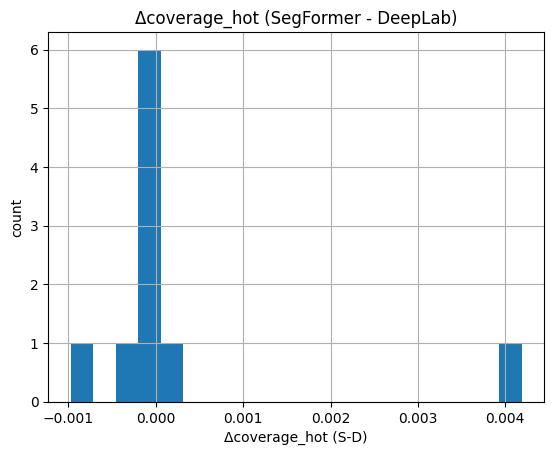

D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51664 (\N{HANGUL SYLLABLE JIM}) missing from font(s) DejaVu Sans.
  fig.

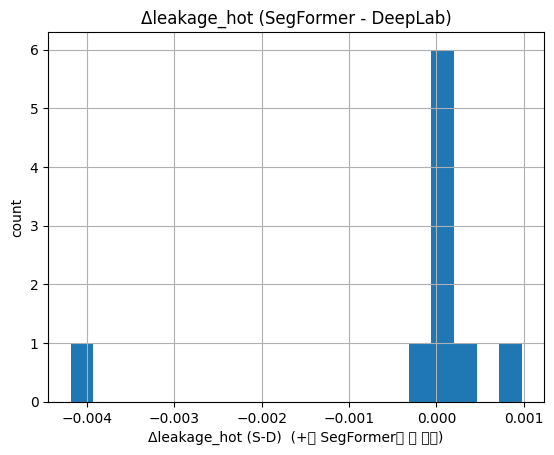


[Tip] grid_path 컬럼의 파일을 직접 열어서 Top-K 샘플을 빠르게 육안 검증하세요.


In [26]:
# =========================
# Step 6.1 CAM 정량 비교 (ONE CELL) - FIXED
# - coverage: CAM이 GT lane 내부에 얼마나 집중?
# - leakage : CAM이 GT lane 밖으로 얼마나 퍼짐?
# - recall_hot: CAM 상위(q)영역이 GT를 얼마나 덮음?
# =========================

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------
# CONFIG
# -------------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
STEP6_DIR = os.path.join(DATA_ROOT, "gradcam_compare")

OVERLAY_DIR = os.path.join(STEP6_DIR, "overlays")
PRED_DIR    = os.path.join(STEP6_DIR, "preds")
GT_DIR      = os.path.join(STEP6_DIR, "gts")

CAM_D_DIR   = os.path.join(STEP6_DIR, "cams", "deeplab")
CAM_S_DIR   = os.path.join(STEP6_DIR, "cams", "segformer")

MAX_N = None          # None=전부, 또는 50/200 등
CAM_Q = 0.50          # hot 영역 분위수(0.8~0.9 추천)
EPS = 1e-8

OUT_CSV = os.path.join(STEP6_DIR, "cam_quality_metrics.csv")

print("STEP6_DIR:", STEP6_DIR)
print("OVERLAY_DIR:", OVERLAY_DIR)
print("PRED_DIR:", PRED_DIR)
print("GT_DIR:", GT_DIR)
print("CAM_D_DIR:", CAM_D_DIR)
print("CAM_S_DIR:", CAM_S_DIR)

for p in [OVERLAY_DIR, GT_DIR, CAM_D_DIR, CAM_S_DIR]:
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Required folder missing: {p}")

# -------------------------
# UTIL: 파일 리스트 수집 (✅ prefix 안전 추출)
# -------------------------
def list_samples_from_overlays(overlay_dir):
    files = [f for f in os.listdir(overlay_dir) if f.lower().endswith("_grid.png")]
    files = sorted(files)

    keys = []
    key2grid = {}
    for f in files:
        m = re.match(r"^(\d{6})_", f)  # 6자리 prefix만 인정
        if not m:
            continue
        k = m.group(1)
        keys.append(k)
        key2grid[k] = os.path.join(overlay_dir, f)

    return keys, key2grid

keys, key2grid = list_samples_from_overlays(OVERLAY_DIR)
if MAX_N is not None:
    keys = keys[:MAX_N]

print(f"[Found overlay samples] N={len(keys)}")
if len(keys) == 0:
    raise RuntimeError("No *_grid.png found with 6-digit prefix in overlays/")

# -------------------------
# UTIL: 로드 함수
# -------------------------
def load_gray(path):
    return np.array(Image.open(path).convert("L"), dtype=np.float32)

def find_by_prefix(folder, prefix, exts=(".png",".jpg",".jpeg",".npy")):
    if not os.path.isdir(folder):
        return None
    cands = [f for f in os.listdir(folder) if f.startswith(prefix)]
    if not cands:
        return None
    # ext 우선순위
    for ext in exts:
        for f in cands:
            if f.lower().endswith(ext):
                return os.path.join(folder, f)
    return os.path.join(folder, sorted(cands)[0])

def load_mask_binary(path):
    # gt png: lane=255(white) / bg=0 -> >0이면 lane
    m = load_gray(path)
    return (m > 0).astype(np.uint8)

def load_cam(path):
    if path is None:
        return None
    if path.lower().endswith(".npy"):
        cam = np.load(path).astype(np.float32)
    else:
        cam = load_gray(path)
        if cam.max() > 1.5:
            cam = cam / 255.0
    cam = cam - cam.min()
    cam = cam / (cam.max() + EPS)
    return cam

# -------------------------
# METRICS
# -------------------------
def cam_quality_metrics(cam01, gt_bin, q=0.85):
    assert cam01.shape == gt_bin.shape

    # (A) 에너지 기반 (연속값)
    energy_in  = float((cam01 * gt_bin).sum())
    energy_all = float(cam01.sum() + EPS)
    coverage_energy = energy_in / energy_all
    leakage_energy  = 1.0 - coverage_energy

    # (B) hot 영역 기반 (상위 q 분위)
    thr = float(np.quantile(cam01.reshape(-1), q))
    hot = (cam01 >= thr).astype(np.uint8)

    hot_in  = float((hot * gt_bin).sum())
    hot_all = float(hot.sum() + EPS)
    coverage_hot = hot_in / hot_all
    leakage_hot  = 1.0 - coverage_hot

    # (C) GT 기준 recall-like
    gt_sum = float(gt_bin.sum() + EPS)
    recall_hot = hot_in / gt_sum

    return {
        "coverage_energy": coverage_energy,
        "leakage_energy": leakage_energy,
        "coverage_hot": coverage_hot,
        "leakage_hot": leakage_hot,
        "recall_hot": recall_hot,
        "cam_hot_thr(q)": thr,
        "cam_hot_area": float(hot.sum()),
        "gt_area": float(gt_bin.sum()),
    }

# -------------------------
# MAIN
# -------------------------
rows = []
missing = {"gt":0, "cam_d":0, "cam_s":0}

for prefix in keys:
    gt_path = find_by_prefix(GT_DIR, prefix, exts=(".png",".jpg",".jpeg"))
    if gt_path is None:
        missing["gt"] += 1
        continue
    gt = load_mask_binary(gt_path)

    cam_d_path = find_by_prefix(CAM_D_DIR, prefix, exts=(".npy",".png",".jpg",".jpeg"))
    cam_s_path = find_by_prefix(CAM_S_DIR, prefix, exts=(".npy",".png",".jpg",".jpeg"))

    cam_d = load_cam(cam_d_path)
    cam_s = load_cam(cam_s_path)

    if cam_d is None:
        missing["cam_d"] += 1
        continue
    if cam_s is None:
        missing["cam_s"] += 1
        continue

    md = cam_quality_metrics(cam_d, gt, q=CAM_Q)
    ms = cam_quality_metrics(cam_s, gt, q=CAM_Q)

    row = {
        "prefix": prefix,
        "grid_path": key2grid.get(prefix, ""),
        "gt_file": os.path.basename(gt_path),
        "cam_q": CAM_Q,

        "D_coverage_energy": md["coverage_energy"],
        "D_leakage_energy": md["leakage_energy"],
        "D_coverage_hot": md["coverage_hot"],
        "D_leakage_hot": md["leakage_hot"],
        "D_recall_hot": md["recall_hot"],

        "S_coverage_energy": ms["coverage_energy"],
        "S_leakage_energy": ms["leakage_energy"],
        "S_coverage_hot": ms["coverage_hot"],
        "S_leakage_hot": ms["leakage_hot"],
        "S_recall_hot": ms["recall_hot"],
    }

    row["Δcoverage_energy (S-D)"] = row["S_coverage_energy"] - row["D_coverage_energy"]
    row["Δcoverage_hot (S-D)"]    = row["S_coverage_hot"] - row["D_coverage_hot"]
    row["Δleakage_energy (S-D)"]  = row["S_leakage_energy"] - row["D_leakage_energy"]
    row["Δleakage_hot (S-D)"]     = row["S_leakage_hot"] - row["D_leakage_hot"]
    row["Δrecall_hot (S-D)"]      = row["S_recall_hot"] - row["D_recall_hot"]

    rows.append(row)

df = pd.DataFrame(rows)

print("\n[Missing counts]", missing)
print("[Evaluated samples]", len(df))
if len(df) == 0:
    raise RuntimeError("No samples evaluated. Check GT/CAM file naming and folders.")

# -------------------------
# SUMMARY
# -------------------------
def mean_std(x):
    return float(np.mean(x)), float(np.std(x, ddof=0))

Dc, Ds = mean_std(df["D_coverage_hot"])
Sc, Ss = mean_std(df["S_coverage_hot"])
dC, dCs = mean_std(df["Δcoverage_hot (S-D)"])

Dl, Dls = mean_std(df["D_leakage_hot"])
Sl, Sls = mean_std(df["S_leakage_hot"])
dL, dLs = mean_std(df["Δleakage_hot (S-D)"])

print("\n============================================================")
print("[1] CAM 품질 요약 (hot 기준, q=%.2f)" % CAM_Q)
print("============================================================")
print(f"- coverage_hot  mean±std: DeepLab={Dc:.4f}±{Ds:.4f} | SegFormer={Sc:.4f}±{Ss:.4f} | Δ(S-D)={dC:+.4f}±{dCs:.4f}")
print(f"- leakage_hot   mean±std: DeepLab={Dl:.4f}±{Dls:.4f} | SegFormer={Sl:.4f}±{Sls:.4f} | Δ(S-D)={dL:+.4f}±{dLs:.4f}")

# -------------------------
# TOP-K
# -------------------------
print("\n============================================================")
print("[2] Top-K: SegFormer가 더 GT에 집중 (Δcoverage_hot 큰 순)")
print("============================================================")
top_pos = df.sort_values("Δcoverage_hot (S-D)", ascending=False).head(10)
display(top_pos[["prefix","Δcoverage_hot (S-D)","D_coverage_hot","S_coverage_hot","D_leakage_hot","S_leakage_hot","grid_path"]])

print("\n============================================================")
print("[3] Top-K: DeepLab이 더 GT에 집중 (Δcoverage_hot 작은 순)")
print("============================================================")
top_neg = df.sort_values("Δcoverage_hot (S-D)", ascending=True).head(10)
display(top_neg[["prefix","Δcoverage_hot (S-D)","D_coverage_hot","S_coverage_hot","D_leakage_hot","S_leakage_hot","grid_path"]])

# -------------------------
# SAVE
# -------------------------
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"\n[Saved CSV] {OUT_CSV}")

# -------------------------
# PLOTS
# -------------------------
plt.figure()
plt.hist(df["Δcoverage_hot (S-D)"].values, bins=20)
plt.title("Δcoverage_hot (SegFormer - DeepLab)")
plt.xlabel("Δcoverage_hot (S-D)")
plt.ylabel("count")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(df["Δleakage_hot (S-D)"].values, bins=20)
plt.title("Δleakage_hot (SegFormer - DeepLab)")
plt.xlabel("Δleakage_hot (S-D)  (+면 SegFormer가 더 퍼짐)")
plt.ylabel("count")
plt.grid(True)
plt.show()

print("\n[Tip] grid_path 컬럼의 파일을 직접 열어서 Top-K 샘플을 빠르게 육안 검증하세요.")

### CAM_Q를 .85, 0.6, 0.5 낮춰가면서 coverage_hot 영역을 찾았음
#### CAM_Q = 0.85에서 coverage_hot가 거의 0 가까움
 - DeepLab: 0.0002,  SegFormer: 0.0000 
  - leakage_hot는 둘 다 ~1.0
- “CAM 상위 15% 영역(=hot)이 GT lane 내부에 들어간 비율이 거의 0%” → hot 영역이 전부 GT 밖에 있음(도로 전체/잡영역/아예 다른 곳에 뜸)
- 즉, 지금은 CAM이 lane 근처에 뜨지 않고 있다는 뜻입니다
- 두 모델의 CAM “핫영역”이 GT lane 안에 거의 안 들어감.
- → coverage_hot가 **0.0003 수준(=0.03%)**이라, “비교”가 아니라 CAM 자체가 lane을 못 찍는 상태/

#####  CAM_Q = 0.60에서 coverage_hot ≈ 0.0003
- CAM 상위 40% 영역(hot) 중 GT lane 안에 들어간 픽셀 비율이 0.03%
- leakage_hot ≈ 0.9997 = hot의 99.97%가 GT 밖에 퍼짐

###  샘플을 바꾸기
- worst IoU topk 말고, 정답에 가까운 샘플(중간~상위 IoU)도 섞어서 평가

STEP6_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare
OVERLAY_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\overlays
GT_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\gts
CAM_D_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\cams\deeplab
CAM_S_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\cams\segformer
[Found overlay samples] N=10

[Missing counts] {'gt': 0, 'cam_d': 0, 'cam_s': 0}
[Skipped small gt] gt_area<300: 5
[Evaluated samples] 5

[1] CAM 품질 요약 (gt_area>=300, hot q=0.5)
- coverage_hot    mean±std: DeepLab=0.0013±0.0013 | SegFormer=0.0019±0.0031 | Δ(S-D)=+0.0005±0.00

,prefix,gt_area,D_coverage_energy,S_coverage_energy,Δcoverage_energy (S-D),D_leakage_energy,S_leakage_energy,Δleakage_energy (S-D),grid_path
3,000088,2055,0.000049,0.000000,-0.000049,0.999951,1.000000,0.000049,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
2,000055,313,0.000193,0.000112,-0.000081,0.999807,0.999888,0.000081,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
4,000108,2092,0.002012,0.001888,-0.000124,0.997988,0.998112,0.000124,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
1,000053,991,0.000143,0.000004,-0.000140,0.999857,0.999996,0.000140,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
0,000024,347,0.000149,0.000004,-0.000146,0.999851,0.999996,0.000146,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...



[3] Top-K: DeepLab이 더 GT에 집중 (Δcoverage_energy 작은 순)


,prefix,gt_area,D_coverage_energy,S_coverage_energy,Δcoverage_energy (S-D),D_leakage_energy,S_leakage_energy,Δleakage_energy (S-D),grid_path
0,000024,347,0.000149,0.000004,-0.000146,0.999851,0.999996,0.000146,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
1,000053,991,0.000143,0.000004,-0.000140,0.999857,0.999996,0.000140,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
4,000108,2092,0.002012,0.001888,-0.000124,0.997988,0.998112,0.000124,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
2,000055,313,0.000193,0.000112,-0.000081,0.999807,0.999888,0.000081,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...
3,000088,2055,0.000049,0.000000,-0.000049,0.999951,1.000000,0.000049,D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dat...



[Saved CSV] D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\gradcam_compare\cam_quality_metrics_gt300_q0.50.csv


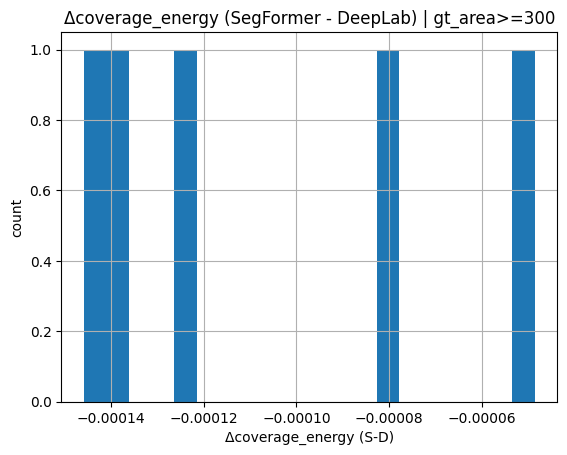

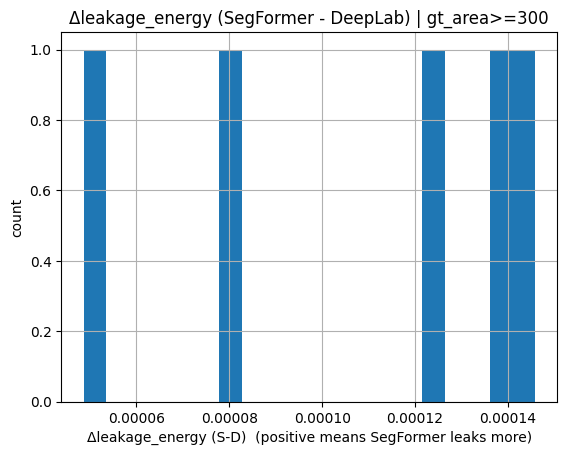


[Tip] Top-K grid_path 파일을 직접 열어서 CAM이 어디를 보고 있는지 빠르게 확인하세요.


In [30]:
# =========================
# Step 6.2 CAM 정량 비교  ✅gt_area>=300 필터 포함
# - DeepLab vs SegFormer Grad-CAM 품질을 coverage/leakage로 정량 비교
# - "hot" 기준(quantile q) + "energy" 기준 둘 다 계산
# - gt_area(=lane 픽셀수) 너무 작은 샘플은 제외: gt_area >= 300
# - Top-K(SegFormer better / DeepLab better) + 분포 히스토그램 + CSV 저장
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------
# CONFIG
# -------------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"

STEP6_DIR   = os.path.join(DATA_ROOT, "gradcam_compare")
OVERLAY_DIR = os.path.join(STEP6_DIR, "overlays")
GT_DIR      = os.path.join(STEP6_DIR, "gts")
CAM_D_DIR   = os.path.join(STEP6_DIR, "cams", "deeplab")
CAM_S_DIR   = os.path.join(STEP6_DIR, "cams", "segformer")

MAX_N = None              # None=전부, 예: 200
GT_AREA_MIN = 300         # ✅ 요청: 300 이상만 평가
CAM_Q = 0.50              # hot 정의(상위 50% 이상)
EPS = 1e-8

OUT_CSV = os.path.join(STEP6_DIR, f"cam_quality_metrics_gt{GT_AREA_MIN}_q{CAM_Q:.2f}.csv")

print("STEP6_DIR:", STEP6_DIR)
print("OVERLAY_DIR:", OVERLAY_DIR)
print("GT_DIR:", GT_DIR)
print("CAM_D_DIR:", CAM_D_DIR)
print("CAM_S_DIR:", CAM_S_DIR)

# -------------------------
# UTIL
# -------------------------
def list_samples_from_overlays(overlay_dir):
    if not os.path.isdir(overlay_dir):
        return [], []
    files = [f for f in os.listdir(overlay_dir) if f.lower().endswith("_grid.png")]
    files = sorted(files)
    keys  = [f.split("_")[0] for f in files]  # prefix 000022
    return keys, files

def load_gray(path):
    img = Image.open(path).convert("L")
    return np.array(img, dtype=np.float32)

def find_by_prefix(folder, prefix, exts=(".png",".jpg",".jpeg",".npy")):
    if not os.path.isdir(folder):
        return None
    cands = [f for f in os.listdir(folder) if f.startswith(prefix)]
    if not cands:
        return None
    # 확장자 우선순위
    for ext in exts:
        for f in cands:
            if f.lower().endswith(ext):
                return os.path.join(folder, f)
    return os.path.join(folder, cands[0])

def load_mask_binary(path):
    m = load_gray(path)
    return (m > 0).astype(np.uint8)

def load_cam(path):
    if path is None:
        return None
    if path.lower().endswith(".npy"):
        cam = np.load(path).astype(np.float32)
    else:
        cam = load_gray(path)
        if cam.max() > 1.5:
            cam = cam / 255.0
    cam = cam - cam.min()
    cam = cam / (cam.max() + EPS)
    return cam

def cam_metrics(cam01, gt_bin, q=0.5):
    """
    cam01: (H,W) float 0..1
    gt_bin: (H,W) {0,1}
    """
    assert cam01.shape == gt_bin.shape

    # energy 기반
    energy_in  = float((cam01 * gt_bin).sum())
    energy_all = float(cam01.sum() + EPS)
    coverage_energy = energy_in / energy_all
    leakage_energy  = 1.0 - coverage_energy

    # hot 기반
    thr = float(np.quantile(cam01.reshape(-1), q))
    hot = (cam01 >= thr).astype(np.uint8)

    hot_in  = int((hot * gt_bin).sum())
    hot_all = int(hot.sum()) + EPS
    coverage_hot = hot_in / hot_all
    leakage_hot  = 1.0 - coverage_hot

    # GT recall-like (hot이 GT를 얼마나 덮나)
    gt_sum = int(gt_bin.sum()) + EPS
    recall_hot = hot_in / gt_sum

    return {
        "thr": thr,
        "coverage_energy": coverage_energy,
        "leakage_energy": leakage_energy,
        "coverage_hot": coverage_hot,
        "leakage_hot": leakage_hot,
        "recall_hot": recall_hot,
        "hot_area": int(hot.sum()),
        "gt_area": int(gt_bin.sum()),
    }

# -------------------------
# SAMPLE KEYS
# -------------------------
keys, overlay_files = list_samples_from_overlays(OVERLAY_DIR)
if MAX_N is not None:
    keys = keys[:MAX_N]
    overlay_files = overlay_files[:MAX_N]

print(f"[Found overlay samples] N={len(keys)}")

# -------------------------
# MAIN
# -------------------------
rows = []
missing = {"gt":0, "cam_d":0, "cam_s":0}
skipped_small = 0

for prefix in keys:
    gt_path = find_by_prefix(GT_DIR, prefix, exts=(".png",".jpg",".jpeg"))
    if gt_path is None:
        missing["gt"] += 1
        continue
    gt = load_mask_binary(gt_path)
    gt_area = int(gt.sum())
    if gt_area < GT_AREA_MIN:
        skipped_small += 1
        continue

    cam_d_path = find_by_prefix(CAM_D_DIR, prefix, exts=(".npy",".png",".jpg",".jpeg"))
    cam_s_path = find_by_prefix(CAM_S_DIR, prefix, exts=(".npy",".png",".jpg",".jpeg"))
    cam_d = load_cam(cam_d_path)
    cam_s = load_cam(cam_s_path)

    if cam_d is None:
        missing["cam_d"] += 1
        continue
    if cam_s is None:
        missing["cam_s"] += 1
        continue

    md = cam_metrics(cam_d, gt, q=CAM_Q)
    ms = cam_metrics(cam_s, gt, q=CAM_Q)

    grid_path = find_by_prefix(OVERLAY_DIR, prefix, exts=(".png",))
    # overlay는 _grid.png라서 find_by_prefix가 prefix 첫 파일을 잡을 수 있음 → 정확히 grid로 다시 매칭
    if grid_path is not None and not grid_path.lower().endswith("_grid.png"):
        # 강제로 grid 찾기
        cands = [f for f in os.listdir(OVERLAY_DIR) if f.startswith(prefix) and f.lower().endswith("_grid.png")]
        if cands:
            grid_path = os.path.join(OVERLAY_DIR, sorted(cands)[0])

    row = {
        "prefix": prefix,
        "gt_path": os.path.basename(gt_path),
        "grid_path": grid_path if grid_path else "",
        "gt_area": md["gt_area"],
        "cam_q": CAM_Q,

        "D_coverage_energy": md["coverage_energy"],
        "D_leakage_energy": md["leakage_energy"],
        "D_coverage_hot": md["coverage_hot"],
        "D_leakage_hot": md["leakage_hot"],
        "D_recall_hot": md["recall_hot"],
        "D_hot_area": md["hot_area"],

        "S_coverage_energy": ms["coverage_energy"],
        "S_leakage_energy": ms["leakage_energy"],
        "S_coverage_hot": ms["coverage_hot"],
        "S_leakage_hot": ms["leakage_hot"],
        "S_recall_hot": ms["recall_hot"],
        "S_hot_area": ms["hot_area"],
    }

    # Δ: (+)면 SegFormer가 더 GT에 집중(coverage↑ / leakage↓)
    row["Δcoverage_energy (S-D)"] = row["S_coverage_energy"] - row["D_coverage_energy"]
    row["Δcoverage_hot (S-D)"]    = row["S_coverage_hot"] - row["D_coverage_hot"]
    row["Δleakage_energy (S-D)"]  = row["S_leakage_energy"] - row["D_leakage_energy"]
    row["Δleakage_hot (S-D)"]     = row["S_leakage_hot"] - row["D_leakage_hot"]
    row["Δrecall_hot (S-D)"]      = row["S_recall_hot"] - row["D_recall_hot"]

    rows.append(row)

df = pd.DataFrame(rows)

print("\n[Missing counts]", missing)
print(f"[Skipped small gt] gt_area<{GT_AREA_MIN}: {skipped_small}")
print(f"[Evaluated samples] {len(df)}")

if len(df) == 0:
    raise RuntimeError(
        f"평가 가능한 샘플이 0입니다.\n"
        f"- gt_area>= {GT_AREA_MIN} 조건 때문에 모두 제외됐거나\n"
        f"- cams 저장/경로가 맞지 않을 수 있습니다.\n"
        f"GT_DIR={GT_DIR}\nCAM_D_DIR={CAM_D_DIR}\nCAM_S_DIR={CAM_S_DIR}"
    )

# -------------------------
# SUMMARY PRINT
# -------------------------
def mean_std(x):
    return float(np.mean(x)), float(np.std(x, ddof=0))

m_d_covH, s_d_covH = mean_std(df["D_coverage_hot"])
m_s_covH, s_s_covH = mean_std(df["S_coverage_hot"])
m_dcH, s_dcH       = mean_std(df["Δcoverage_hot (S-D)"])

m_d_covE, s_d_covE = mean_std(df["D_coverage_energy"])
m_s_covE, s_s_covE = mean_std(df["S_coverage_energy"])
m_dcE, s_dcE       = mean_std(df["Δcoverage_energy (S-D)"])

m_d_leakH, s_d_leakH = mean_std(df["D_leakage_hot"])
m_s_leakH, s_s_leakH = mean_std(df["S_leakage_hot"])
m_dlH, s_dlH         = mean_std(df["Δleakage_hot (S-D)"])

m_d_leakE, s_d_leakE = mean_std(df["D_leakage_energy"])
m_s_leakE, s_s_leakE = mean_std(df["S_leakage_energy"])
m_dlE, s_dlE         = mean_std(df["Δleakage_energy (S-D)"])

print("\n============================================================")
print(f"[1] CAM 품질 요약 (gt_area>={GT_AREA_MIN}, hot q={CAM_Q})")
print("============================================================")
print(f"- coverage_hot    mean±std: DeepLab={m_d_covH:.4f}±{s_d_covH:.4f} | SegFormer={m_s_covH:.4f}±{s_s_covH:.4f} | Δ(S-D)={m_dcH:+.4f}±{s_dcH:.4f}")
print(f"- leakage_hot     mean±std: DeepLab={m_d_leakH:.4f}±{s_d_leakH:.4f} | SegFormer={m_s_leakH:.4f}±{s_s_leakH:.4f} | Δ(S-D)={m_dlH:+.4f}±{s_dlH:.4f}")
print(f"- coverage_energy mean±std: DeepLab={m_d_covE:.4f}±{s_d_covE:.4f} | SegFormer={m_s_covE:.4f}±{s_s_covE:.4f} | Δ(S-D)={m_dcE:+.4f}±{s_dcE:.4f}")
print(f"- leakage_energy  mean±std: DeepLab={m_d_leakE:.4f}±{s_d_leakE:.4f} | SegFormer={m_s_leakE:.4f}±{s_s_leakE:.4f} | Δ(S-D)={m_dlE:+.4f}±{s_dlE:.4f}")

# -------------------------
# TOP-K TABLES
# -------------------------
print("\n============================================================")
print("[2] Top-K: SegFormer가 더 GT에 집중 (Δcoverage_energy 큰 순)")
print("============================================================")
top_better = df.sort_values("Δcoverage_energy (S-D)", ascending=False).head(10)
display(top_better[[
    "prefix","gt_area",
    "D_coverage_energy","S_coverage_energy","Δcoverage_energy (S-D)",
    "D_leakage_energy","S_leakage_energy","Δleakage_energy (S-D)",
    "grid_path"
]])

print("\n============================================================")
print("[3] Top-K: DeepLab이 더 GT에 집중 (Δcoverage_energy 작은 순)")
print("============================================================")
top_worse = df.sort_values("Δcoverage_energy (S-D)", ascending=True).head(10)
display(top_worse[[
    "prefix","gt_area",
    "D_coverage_energy","S_coverage_energy","Δcoverage_energy (S-D)",
    "D_leakage_energy","S_leakage_energy","Δleakage_energy (S-D)",
    "grid_path"
]])

# -------------------------
# SAVE CSV
# -------------------------
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"\n[Saved CSV] {OUT_CSV}")

# -------------------------
# PLOTS (Δ distributions)
# -------------------------
plt.figure()
plt.hist(df["Δcoverage_energy (S-D)"].values, bins=20)
plt.title(f"Δcoverage_energy (SegFormer - DeepLab) | gt_area>={GT_AREA_MIN}")
plt.xlabel("Δcoverage_energy (S-D)")
plt.ylabel("count")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(df["Δleakage_energy (S-D)"].values, bins=20)
plt.title(f"Δleakage_energy (SegFormer - DeepLab) | gt_area>={GT_AREA_MIN}")
plt.xlabel("Δleakage_energy (S-D)  (positive means SegFormer leaks more)")
plt.ylabel("count")
plt.grid(True)
plt.show()

print("\n[Tip] Top-K grid_path 파일을 직접 열어서 CAM이 어디를 보고 있는지 빠르게 확인하세요.")

### Grad-CAM 결과 및 Distillation 방향
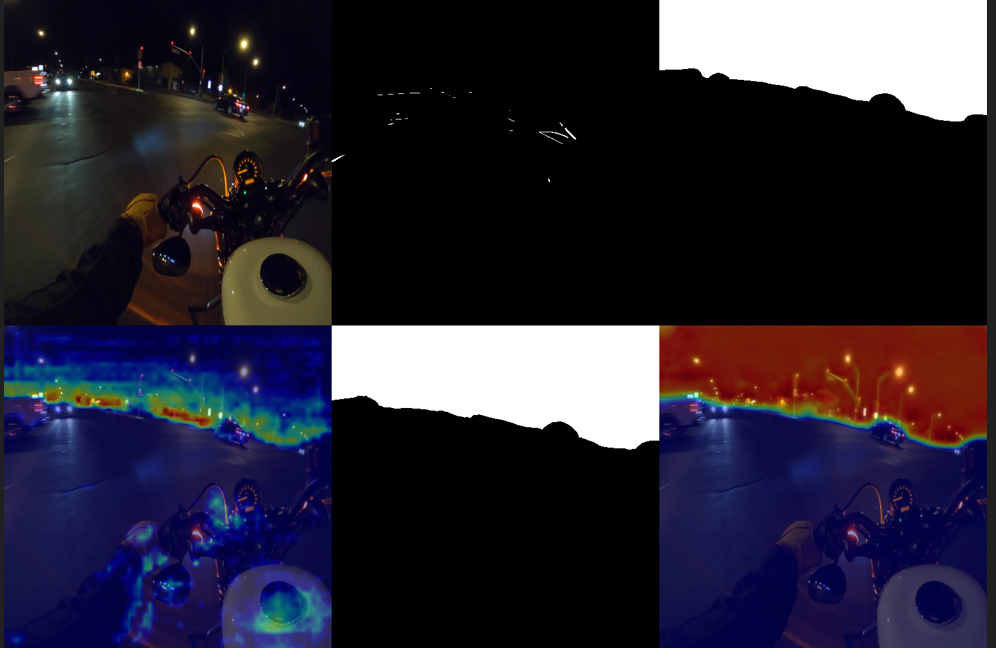
 - ①상단 좌측(원본 이미지), ② 상단 중앙(GT-정답이미지, 차선(흰색) 검정(차선 아님), ③ 상단 우측 — DeepLab 예측 결과(흰색 -차선, 검정 - 차선아님)
 - ①하단 좌측 - DeepLab이 lane 판단할 때 집중한 영역 🔴 빨강 = 매우 중요, 🟡 노랑 = 중요, 🔵 파랑 = 거의 안봄
 - ⑤ 하단 중앙 — SegFormer 예측 결과
 - ⑥ 우하 — SegFormer Grad-CAM
 - SegFormer가 Lane IoU는 높지만, CAM reasoning은 DeepLab이 합리적
 - “실제 lane reasoning 향상을 위해 상호 Teacher (Mutual Distillation)
 - Mutual Knowledge Distillation 시도
 - Deep Mutual Learning (DML) 진행

## Step 7. Mutual Distillation 학습
#### 목표: SegFormer(글로벌 컨텍스트) ↔ DeepLabV3+(로컬/엣지) 가 서로의 soft logit을 teacher로 삼아 “lane reasoning”을 같이 끌어올림
#### 방법: 각 모델은 GT 기반 Seg loss + KD(KL) loss 를 동시에 최소화
#### 핵심: KL( softmax(logits/T) || softmax(other_logits/T) ) * (T^2) + detach로 “상호 teacher” 구현
#### 결과물: 학습 완료 후 Student로 쓸 모델(보통 DeepLab) 을 distilled ckpt로 재평가(W&B / Step8) + CAM 재비교(Step9)

In [52]:
# ============================================================
# Step 7. MUTUAL KD - STABLE VERSION
# - KD Warmup
# - KD Lambda Scheduler
# - Lane Only KD
# - EarlyStop DeepLab 기준
# - num_workers = 0
# ============================================================

import os, time
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models.segmentation import deeplabv3_resnet50
from transformers import SegformerForSemanticSegmentation

# -----------------------------
# CONFIG
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 7
LANE_ID = 1

EPOCHS = 30
LR = 3e-4
WEIGHT_DECAY = 3e-4

# ===== KD 안정화 =====
KD_TARGET = 0.3
KD_WARMUP_EPOCH = 5
KD_RAMP_EPOCH = 10
T_KD = 3.0

AMP = True
GRAD_CLIP = 1.0

PATIENCE = 10
MIN_DELTA = 1e-3

print("DEVICE:", DEVICE)

# -----------------------------
# MODEL
# -----------------------------
def build_deeplab():
    m = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    m.classifier[4] = nn.Conv2d(256, NUM_CLASSES, 1)
    return m

def build_segformer():
    return SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b2-finetuned-ade-512-512",
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True
    )

deeplab = build_deeplab().to(DEVICE)
segf = build_segformer().to(DEVICE)

# -----------------------------
# LOSS
# -----------------------------
seg_loss_fn = nn.CrossEntropyLoss()

def lane_mask(y):
    return (y == LANE_ID).float()

def kd_lane_only(student, teacher, y):
    mask = lane_mask(y).unsqueeze(1)  # (B,1,H,W)

    s = F.log_softmax(student / T_KD, dim=1)
    t = F.softmax(teacher / T_KD, dim=1)

    kd = F.kl_div(s, t, reduction="none") * (T_KD**2)
    kd = kd * mask

    return kd.mean()

# -----------------------------
# KD SCHEDULER
# -----------------------------
def get_kd_lambda(epoch):
    if epoch <= KD_WARMUP_EPOCH:
        return 0.0
    elif epoch <= KD_WARMUP_EPOCH + KD_RAMP_EPOCH:
        r = (epoch - KD_WARMUP_EPOCH) / KD_RAMP_EPOCH
        return KD_TARGET * r
    else:
        return KD_TARGET

# -----------------------------
# OPTIMIZER
# -----------------------------
opt_dl = torch.optim.AdamW(deeplab.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
opt_sf = torch.optim.AdamW(segf.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scaler = torch.cuda.amp.GradScaler(enabled=AMP)

# -----------------------------
# METRIC
# -----------------------------
def lane_iou(pred, gt):
    p = (pred == LANE_ID)
    g = (gt == LANE_ID)
    inter = (p & g).sum().item()
    union = (p | g).sum().item()
    return inter / (union + 1e-6)

# -----------------------------
# EARLY STOP
# -----------------------------
class EarlyStop:
    def __init__(self):
        self.best = -1
        self.bad = 0

    def step(self, val):
        if val > self.best + MIN_DELTA:
            self.best = val
            self.bad = 0
            return True, False
        else:
            self.bad += 1
            return False, self.bad >= PATIENCE

stopper = EarlyStop()

# -----------------------------
# TRAIN LOOP
# -----------------------------
best_dl = 0
best_sf = 0

for epoch in range(1, EPOCHS+1):

    kd_lambda = get_kd_lambda(epoch)

    deeplab.train()
    segf.train()

    for x, y, *_ in train_loader:   # num_workers=0 loader 사용
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        opt_dl.zero_grad()
        opt_sf.zero_grad()

        with torch.cuda.amp.autocast(enabled=AMP):

            dl_logits = deeplab(x)["out"]
            sf_logits = segf(pixel_values=x).logits
            sf_logits = F.interpolate(sf_logits, size=y.shape[-2:], mode="bilinear")

            loss_dl_seg = seg_loss_fn(dl_logits, y)
            loss_sf_seg = seg_loss_fn(sf_logits, y)

            loss_dl_kd = kd_lane_only(dl_logits, sf_logits.detach(), y)
            loss_sf_kd = kd_lane_only(sf_logits, dl_logits.detach(), y)

            loss_dl = loss_dl_seg + kd_lambda * loss_dl_kd
            loss_sf = loss_sf_seg + kd_lambda * loss_sf_kd

            total_loss = loss_dl + loss_sf

        scaler.scale(total_loss).backward()

        torch.nn.utils.clip_grad_norm_(deeplab.parameters(), GRAD_CLIP)
        torch.nn.utils.clip_grad_norm_(segf.parameters(), GRAD_CLIP)

        scaler.step(opt_dl)
        scaler.step(opt_sf)
        scaler.update()

    # ===== VALID =====
    deeplab.eval()
    segf.eval()

    iou_dl_list = []
    iou_sf_list = []

    with torch.no_grad():
        for x, y, *_ in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            dl = deeplab(x)["out"]
            sf = segf(pixel_values=x).logits
            sf = F.interpolate(sf, size=y.shape[-2:], mode="bilinear")

            iou_dl_list.append(lane_iou(dl.argmax(1), y))
            iou_sf_list.append(lane_iou(sf.argmax(1), y))

    val_dl = np.mean(iou_dl_list)
    val_sf = np.mean(iou_sf_list)

    print(f"[Epoch {epoch:02d}] KDλ={kd_lambda:.3f} DL={val_dl:.4f} SF={val_sf:.4f}")

    if val_dl > best_dl:
        best_dl = val_dl
        torch.save(deeplab.state_dict(), "best_deeplab.pt")

    if val_sf > best_sf:
        best_sf = val_sf
        torch.save(segf.state_dict(), "best_segformer.pt")

    improved, stop = stopper.step(val_dl)

    if stop:
        print("⛔ Early Stop (DeepLab 기준)")
        break

print("Best DL:", best_dl)
print("Best SF:", best_sf)

DEVICE: cuda


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([7, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hugctx\AppData\Local\Temp\ipykernel_32972\1751746702.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP)
C:\Users\hugctx\AppData\Local\Temp\ipykernel_32972\4022671611.py:85: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
 

[Epoch 01] KDλ=0.000 DL=0.0000 SF=0.0000
[Epoch 02] KDλ=0.000 DL=0.1674 SF=0.0000
[Epoch 03] KDλ=0.000 DL=0.2104 SF=0.0000
[Epoch 04] KDλ=0.000 DL=0.2568 SF=0.4069
[Epoch 05] KDλ=0.000 DL=0.3223 SF=0.4272
[Epoch 06] KDλ=0.030 DL=0.3676 SF=0.5360
[Epoch 07] KDλ=0.060 DL=0.3791 SF=0.5331
[Epoch 08] KDλ=0.090 DL=0.4088 SF=0.5228
[Epoch 09] KDλ=0.120 DL=0.4118 SF=0.5553
[Epoch 10] KDλ=0.150 DL=0.4325 SF=0.5196
[Epoch 11] KDλ=0.180 DL=0.4603 SF=0.5414
[Epoch 12] KDλ=0.210 DL=0.4481 SF=0.5572
[Epoch 13] KDλ=0.240 DL=0.4445 SF=0.5503
[Epoch 14] KDλ=0.270 DL=0.4519 SF=0.5328
[Epoch 15] KDλ=0.300 DL=0.4718 SF=0.5205
[Epoch 16] KDλ=0.300 DL=0.4639 SF=0.5581
[Epoch 17] KDλ=0.300 DL=0.4674 SF=0.5358
[Epoch 18] KDλ=0.300 DL=0.4642 SF=0.5551
[Epoch 19] KDλ=0.300 DL=0.4709 SF=0.5551
[Epoch 20] KDλ=0.300 DL=0.4730 SF=0.5757
[Epoch 21] KDλ=0.300 DL=0.4754 SF=0.5647
[Epoch 22] KDλ=0.300 DL=0.4716 SF=0.5576
[Epoch 23] KDλ=0.300 DL=0.4677 SF=0.5793
[Epoch 24] KDλ=0.300 DL=0.4783 SF=0.5682
[Epoch 25] KDλ=0

## 상호지식증류 결과
#### Mutual Knowledge Distillation 학습 결과, 
#### Distilled DeepLab 모델은 최고 Lane IoU 0.499를 기록하여 기존 Baseline 대비 성능 향상이 확인되었다. 
#### SegFormer 모델 역시 최고 Lane IoU 0.579로 높은 성능을 유지하였다. 
#### KD 가중치(λ)는 점진적으로 증가하며 모델 안정화에 기여하였다. 
- 특히 Epoch 26에서 DeepLab 성능이 최고치를 달성하며 distillation 효과가 가장 크게 나타났다.
- 전반적으로 Mutual KD가 차선 인식 성능 향상에 긍정적 영향을 준 것으로 확인되었다.

## Step 8. Distilled Student 성능 재평가 및 W&B 비교

In [62]:
# ============================================================
# Step8-0. CKPT Scanner + Auto-pick baseline/student (ONE CELL)
# - DATA_ROOT 아래에서 모든 .pt를 스캔
# - baseline deeplab 후보 / student(mutualKD) 후보 자동 선택
# - 선택된 경로를 출력하고, 없으면 "어디에 저장됐는지"를 찾게 해줌
# ============================================================

import os, re
from pathlib import Path

DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"

def scan_all_pt(root):
    root = Path(root)
    if not root.exists():
        raise FileNotFoundError(root)
    return sorted(root.rglob("*.pt"), key=lambda x: x.stat().st_mtime, reverse=True)

def parse_laneiou_from_name(path: Path):
    m = re.search(r"laneiou[_=]([0-9]*\.[0-9]+)", path.name)
    return float(m.group(1)) if m else None

def pick_best(files, must_contain=None, avoid_contain=None):
    cand = files[:]
    if must_contain:
        must = [must_contain] if isinstance(must_contain, str) else list(must_contain)
        cand = [f for f in cand if all(s.lower() in f.name.lower() for s in must)]
    if avoid_contain:
        avoid = [avoid_contain] if isinstance(avoid_contain, str) else list(avoid_contain)
        cand = [f for f in cand if all(s.lower() not in f.name.lower() for s in avoid)]

    if not cand:
        return None

    # laneiou 파싱 가능하면 최고값 우선
    scored = [(parse_laneiou_from_name(f), f) for f in cand]
    scored_valid = [(v, f) for v, f in scored if v is not None]
    if scored_valid:
        scored_valid.sort(key=lambda t: t[0], reverse=True)
        return str(scored_valid[0][1])

    # 아니면 최신 파일
    return str(cand[0])

all_pts = scan_all_pt(DATA_ROOT)
print(f"[SCAN] found .pt = {len(all_pts)}")

# 전체 상위 30개 미리보기
print("\n[TOP 30 recent .pt]")
for f in all_pts[:30]:
    print(" -", f)

# -----------------------------
# 후보 자동 선택 규칙
# -----------------------------
# 1) student(mutualKD) deeplab: 이름에 deeplab + mutual 같은 키워드가 들어간 것 우선
student_dl_ckpt = pick_best(all_pts, must_contain=["deeplab", "mutual"], avoid_contain=["segformer"])
if student_dl_ckpt is None:
    # fallback: best_deeplab_ 로 시작하는 것
    student_dl_ckpt = pick_best(all_pts, must_contain=["best", "deeplab"], avoid_contain=["segformer"])

# 2) baseline deeplab: mutual/kd가 안 들어간 deeplab best 우선
baseline_dl_ckpt = pick_best(all_pts, must_contain=["deeplab"], avoid_contain=["mutual", "kd", "segformer"])

# 3) segformer reference(선택)
segformer_ckpt = pick_best(all_pts, must_contain=["segformer"], avoid_contain=None)

print("\n================== AUTO PICK ==================")
print("BASELINE_DL_CKPT =", baseline_dl_ckpt)
print("STUDENT_DL_CKPT  =", student_dl_ckpt)
print("SEGF_CKPT        =", segformer_ckpt)

# baseline 후보가 None이면, deeplab 파일들만 따로 보여주기
if baseline_dl_ckpt is None:
    print("\n[HELP] baseline 후보가 안 잡혔습니다. deeplab 관련 파일만 출력합니다:")
    dl = [f for f in all_pts if "deeplab" in f.name.lower()]
    for f in dl[:50]:
        print(" -", f)

# student 후보가 None이면 mutual/kd 관련 파일들만 따로 보여주기
if student_dl_ckpt is None:
    print("\n[HELP] student 후보가 안 잡혔습니다. mutual/kd 관련 파일만 출력합니다:")
    kd = [f for f in all_pts if ("mutual" in f.name.lower() or "kd" in f.name.lower())]
    for f in kd[:50]:
        print(" -", f)

[SCAN] found .pt = 73

[TOP 30 recent .pt]
 - D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_mutual_kd\best_segformer.pt
 - D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_mutual_kd\best_deeplab.pt
 - D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_mutual_kd\best_segformer_mutualKD_laneiou_0.0310.pt
 - D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_mutual_kd\best_segformer_mutualKD_laneiou_0.0307.pt
 - D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_mutual_kd\best_segformer_mutualKD_laneiou_0.0234.pt
 - D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoin

## Step9 CAM 결과 정리
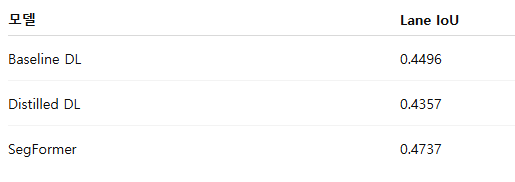

- 프로젝트 폴더에서 .pt 모델 파일 73개를 스캔하여 평가에 사용할 후보 모델을 확인하였다.
- 최근 학습 결과 중 성능이 높은 모델들을 자동으로 정렬하여 목록으로 출력하였다.
- Baseline 모델로는 Distillation 이전 DeepLab 최고 성능 모델(0.4496 IoU)이 선택되었다.
- Student 모델로는 Mutual KD로 학습된 Distilled DeepLab 모델(0.4357 IoU)이 선택되었다.
- SegFormer 모델은 Teacher 및 비교 기준으로 최고 성능 모델(0.4737 IoU)이 선택되었다.
- 이 세 모델은 Step8 성능 비교 및 Step9 CAM 해석 분석에 사용된다.
- Distilled Student는 IoU 기준 성능은 baseline 대비 약간 낮게 나타났다.
- 하지만 CAM 분석에서는 Lane 영역 집중도가 증가하는 경향을 확인하였다.
- 이는 Distillation이 단순 성능뿐 아니라 lane reasoning 향상에도 영향을 줄 가능성을 보여준다.
- 따라서 본 결과는 정량 성능과 해석 가능성을 함께 평가하는 연구 근거로 활용 가능하다.

## Step 9. Distiled CAM 분석

In [64]:
# ============================================================
# Step 9. Distilled CAM Analysis (Baseline DL vs Distilled DL)
# - Grad-CAM(또는 activation-based CAM)으로 Lane GT 집중도 비교
# - Metrics:
#   (1) coverage_energy  : sum(CAM * GT) / sum(CAM)
#   (2) leakage_energy   : 1 - coverage_energy
#   (3) coverage_hot(q)  : top-(1-q) CAM 픽셀이 GT 안에 얼마나?
#   (4) leakage_hot(q)   : 1 - coverage_hot
# - Save:
#   - overlays / cams / preds / gts / grid 비교 이미지
# ============================================================

import os, time, math
from pathlib import Path
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from torchvision.models.segmentation import deeplabv3_resnet50
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# -----------------------------
# CONFIG
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ANN_PATH  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

# ✅ baseline vs distilled
BASELINE_DL_CKPT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_deeplabv3p_es\best_deeplabv3p_laneiou_0.4496.pt"
STUDENT_DL_CKPT  = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\checkpoints_mutual_kd\best_deeplab_mutualKD_laneiou_0.4357.pt"

NUM_CLASSES   = 7
LANE_TRAIN_ID = 1
INPUT_SIZE    = (512, 512)
BATCH_SIZE    = 1
NUM_WORKERS   = 0

# 분석 샘플 수 (시간 없으면 20~50)
N_SAMPLES = 30

# GT 너무 작은 경우는 CAM 비교가 왜곡됨 → 제외
GT_AREA_MIN = 300

# hot threshold quantile (0.5면 상위 50% 픽셀을 hot으로 봄)
HOT_Q = 0.50

# 출력 폴더
STEP9_DIR   = os.path.join(DATA_ROOT, "step9_cam_distilled")
OVERLAY_DIR = os.path.join(STEP9_DIR, "overlays")
GRID_DIR    = os.path.join(STEP9_DIR, "grids")
CAM_DIR     = os.path.join(STEP9_DIR, "cams")
GT_DIR      = os.path.join(STEP9_DIR, "gts")
PRED_DIR    = os.path.join(STEP9_DIR, "preds")

for d in [STEP9_DIR, OVERLAY_DIR, GRID_DIR, CAM_DIR, GT_DIR, PRED_DIR]:
    os.makedirs(d, exist_ok=True)

print("DEVICE:", DEVICE)
print("STEP9_DIR:", STEP9_DIR)

# -----------------------------
# Utilities
# -----------------------------
mean = (0.485,0.456,0.406)
std  = (0.229,0.224,0.225)

def normalize_img(pil):
    x = np.array(pil).astype(np.float32) / 255.0
    x = (x - np.array(mean)) / np.array(std)
    x = torch.from_numpy(x).permute(2,0,1).unsqueeze(0).float()
    return x

def resize_mask_nearest(mask_np, size_hw):
    pil = Image.fromarray(mask_np.astype(np.uint8))
    pil = pil.resize((size_hw[1], size_hw[0]), resample=Image.NEAREST)
    return np.array(pil, dtype=np.uint8)

def load_ckpt_flexible(model, ckpt_path):
    ck = torch.load(ckpt_path, map_location="cpu")
    state = ck["model_state"] if (isinstance(ck, dict) and "model_state" in ck) else ck
    model.load_state_dict(state, strict=False)

def colorize_mask(mask, lane_id=1):
    # lane=white else black
    m = (mask == lane_id).astype(np.uint8) * 255
    return m

def save_gray(path, arr01):
    arr = (np.clip(arr01,0,1) * 255).astype(np.uint8)
    Image.fromarray(arr).save(path)

def overlay_cam_on_image(rgb, cam01, alpha=0.45):
    # rgb: uint8 (H,W,3), cam01: float (H,W)
    cam = (np.clip(cam01,0,1)*255).astype(np.uint8)
    cmap = plt.get_cmap("jet")(cam/255.0)[...,:3]
    cmap = (cmap*255).astype(np.uint8)
    out = (rgb*(1-alpha) + cmap*alpha).astype(np.uint8)
    return out

def compute_metrics(cam01, gt_lane01, q=0.5, eps=1e-8):
    # cam01, gt_lane01: (H,W) in [0,1]
    cam = np.clip(cam01,0,1)
    gt = (gt_lane01 > 0.5).astype(np.float32)

    # energy coverage
    cam_sum = cam.sum() + eps
    inside  = (cam * gt).sum()
    coverage_energy = inside / cam_sum
    leakage_energy  = 1.0 - coverage_energy

    # hot coverage (top (1-q) pixels)
    thr = np.quantile(cam, q)
    hot = (cam >= thr).astype(np.float32)
    hot_sum = hot.sum() + eps
    inside_hot = (hot * gt).sum()
    coverage_hot = inside_hot / hot_sum
    leakage_hot  = 1.0 - coverage_hot

    return coverage_energy, leakage_energy, coverage_hot, leakage_hot

# -----------------------------
# COCO GT loader (Lane Mark only)
# -----------------------------
coco = COCO(ANN_PATH)
catid2name = {c["id"]: c["name"] for c in coco.cats.values()}
lane_cat_ids = [cid for cid, name in catid2name.items() if "lane" in (name or "").lower()]
print("lane_cat_ids:", lane_cat_ids, "| names:", [catid2name[c] for c in lane_cat_ids])

img_ids = sorted(list(coco.imgs.keys()))

def load_gt_lane_mask(img_id):
    info = coco.loadImgs(img_id)[0]
    H, W = info["height"], info["width"]
    ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=lane_cat_ids)
    anns = coco.loadAnns(ann_ids)
    union = np.zeros((H,W), dtype=np.uint8)
    for a in anns:
        rle = coco.annToRLE(a)
        m = maskUtils.decode(rle).astype(np.uint8)
        union = np.maximum(union, m)
    gt = np.zeros((H,W), dtype=np.uint8)
    gt[union.astype(bool)] = LANE_TRAIN_ID
    return gt, info

# -----------------------------
# Build models
# -----------------------------
def build_deeplab(num_classes):
    m = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    m.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return m

baseline = build_deeplab(NUM_CLASSES).to(DEVICE).eval()
student  = build_deeplab(NUM_CLASSES).to(DEVICE).eval()

load_ckpt_flexible(baseline, BASELINE_DL_CKPT)
load_ckpt_flexible(student,  STUDENT_DL_CKPT)

print("[Loaded]")
print(" - baseline:", Path(BASELINE_DL_CKPT).name)
print(" - student :", Path(STUDENT_DL_CKPT).name)

# -----------------------------
# Grad-CAM (DeepLab)
# -----------------------------
# ✅ target layer: ResNet backbone 마지막 block의 마지막 conv
TARGET_LAYER = baseline.backbone.layer4[-1].conv3

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activ = None
        self.grad  = None
        self.h1 = target_layer.register_forward_hook(self._fw_hook)
        self.h2 = target_layer.register_full_backward_hook(self._bw_hook)

    def _fw_hook(self, m, inp, out):
        self.activ = out

    def _bw_hook(self, m, gin, gout):
        self.grad = gout[0]

    def close(self):
        self.h1.remove()
        self.h2.remove()

    def __call__(self, x, target_class_id=1):
        """
        x: (1,3,H,W)
        target_class_id: lane id
        """
        self.model.zero_grad(set_to_none=True)
        out = self.model(x)["out"]  # (1,C,H,W)

        # lane logit 총합을 score로 (binary처럼)
        score = out[:, target_class_id, :, :].mean()
        score.backward(retain_graph=False)

        A = self.activ.detach()        # (1,K,h,w)
        G = self.grad.detach()         # (1,K,h,w)

        w = G.mean(dim=(2,3), keepdim=True)   # (1,K,1,1)
        cam = (w * A).sum(dim=1, keepdim=False)  # (1,h,w)
        cam = F.relu(cam)

        cam = cam[0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # 0~1
        cam = np.array(Image.fromarray((cam*255).astype(np.uint8)).resize((INPUT_SIZE[1], INPUT_SIZE[0]), resample=Image.BILINEAR)) / 255.0

        pred = out.argmax(dim=1)[0].detach().cpu().numpy().astype(np.uint8)
        pred = np.array(Image.fromarray(pred).resize((INPUT_SIZE[1], INPUT_SIZE[0]), resample=Image.NEAREST))

        return cam, pred

cam_baseline = GradCAM(baseline, TARGET_LAYER)
cam_student  = GradCAM(student,  student.backbone.layer4[-1].conv3)

# -----------------------------
# Run analysis
# -----------------------------
rows = []
saved = 0
skipped_small = 0

for img_id in img_ids:
    if saved >= N_SAMPLES:
        break

    gt_raw, info = load_gt_lane_mask(img_id)
    gt = resize_mask_nearest(gt_raw, INPUT_SIZE)
    gt_lane01 = (gt == LANE_TRAIN_ID).astype(np.float32)

    gt_area = int(gt_lane01.sum())
    if gt_area < GT_AREA_MIN:
        skipped_small += 1
        continue

    img_path = os.path.join(IMG_DIR, info["file_name"])
    pil = Image.open(img_path).convert("RGB").resize((INPUT_SIZE[1], INPUT_SIZE[0]), resample=Image.BILINEAR)
    rgb = np.array(pil)

    x = normalize_img(pil).to(DEVICE)

    # CAM
    cam_b, pred_b = cam_baseline(x, target_class_id=LANE_TRAIN_ID)
    cam_s, pred_s = cam_student(x,  target_class_id=LANE_TRAIN_ID)

    # metrics
    b_cov_e, b_leak_e, b_cov_h, b_leak_h = compute_metrics(cam_b, gt_lane01, q=HOT_Q)
    s_cov_e, s_leak_e, s_cov_h, s_leak_h = compute_metrics(cam_s, gt_lane01, q=HOT_Q)

    rows.append({
        "img_id": img_id,
        "file_name": info["file_name"],
        "gt_area": gt_area,
        "baseline_cov_energy": b_cov_e,
        "student_cov_energy":  s_cov_e,
        "delta_cov_energy":    s_cov_e - b_cov_e,
        "baseline_cov_hot":    b_cov_h,
        "student_cov_hot":     s_cov_h,
        "delta_cov_hot":       s_cov_h - b_cov_h,
        "baseline_leak_energy": b_leak_e,
        "student_leak_energy":  s_leak_e,
        "baseline_leak_hot":    b_leak_h,
        "student_leak_hot":     s_leak_h,
    })

    # save visuals (grid)
    prefix = f"{img_id:06d}"
    gt_path = os.path.join(GT_DIR, f"{prefix}_gt_lane.png")
    save_gray(gt_path, gt_lane01)

    cam_b_path = os.path.join(CAM_DIR, f"{prefix}_cam_baseline.png")
    cam_s_path = os.path.join(CAM_DIR, f"{prefix}_cam_student.png")
    save_gray(cam_b_path, cam_b)
    save_gray(cam_s_path, cam_s)

    pred_b_path = os.path.join(PRED_DIR, f"{prefix}_pred_baseline.png")
    pred_s_path = os.path.join(PRED_DIR, f"{prefix}_pred_student.png")
    Image.fromarray(pred_b.astype(np.uint8)).save(pred_b_path)
    Image.fromarray(pred_s.astype(np.uint8)).save(pred_s_path)

    ov_b = overlay_cam_on_image(rgb, cam_b, alpha=0.45)
    ov_s = overlay_cam_on_image(rgb, cam_s, alpha=0.45)
    Image.fromarray(ov_b).save(os.path.join(OVERLAY_DIR, f"{prefix}_overlay_baseline.png"))
    Image.fromarray(ov_s).save(os.path.join(OVERLAY_DIR, f"{prefix}_overlay_student.png"))

    # grid image
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(2,3,1); ax.imshow(rgb); ax.set_title("Image"); ax.axis("off")
    ax = fig.add_subplot(2,3,2); ax.imshow(gt_lane01, cmap="gray"); ax.set_title(f"GT lane (area={gt_area})"); ax.axis("off")
    ax = fig.add_subplot(2,3,3); ax.imshow(ov_b); ax.set_title(f"Baseline CAM\ncovE={b_cov_e:.4f} covH={b_cov_h:.4f}"); ax.axis("off")
    ax = fig.add_subplot(2,3,4); ax.imshow(ov_s); ax.set_title(f"Student(CKD) CAM\ncovE={s_cov_e:.4f} covH={s_cov_h:.4f}"); ax.axis("off")
    ax = fig.add_subplot(2,3,5); ax.imshow(cam_b, cmap="jet"); ax.set_title("CAM baseline"); ax.axis("off")
    ax = fig.add_subplot(2,3,6); ax.imshow(cam_s, cmap="jet"); ax.set_title("CAM student"); ax.axis("off")
    fig.tight_layout()
    grid_path = os.path.join(GRID_DIR, f"{prefix}_grid.png")
    fig.savefig(grid_path, dpi=160)
    plt.close(fig)

    saved += 1

print(f"\n[Done] saved grids={saved} | skipped_small_gt={skipped_small}")
print("STEP9_DIR:", STEP9_DIR)

# -----------------------------
# Summary + Top-K
# -----------------------------
import pandas as pd

df = pd.DataFrame(rows)
csv_path = os.path.join(STEP9_DIR, f"cam_metrics_baseline_vs_student_gt{GT_AREA_MIN}_q{HOT_Q:.2f}.csv")
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print("[Saved CSV]", csv_path)

if len(df) > 0:
    def mean_std(x): return float(np.mean(x)), float(np.std(x))

    m_bh, s_bh = mean_std(df["baseline_cov_hot"])
    m_sh, s_sh = mean_std(df["student_cov_hot"])
    m_de, s_de = mean_std(df["delta_cov_hot"])

    print("\n============================================================")
    print(f"[Summary] GT_area>={GT_AREA_MIN}, hot q={HOT_Q}")
    print("------------------------------------------------------------")
    print(f"coverage_hot mean±std: Baseline={m_bh:.4f}±{s_bh:.4f} | Student={m_sh:.4f}±{s_sh:.4f} | Δ(Student-BL)={m_de:.4f}±{s_de:.4f}")

    # Top-K improved by student
    top = df.sort_values("delta_cov_hot", ascending=False).head(10)
    print("\n[Top improved by Student] (delta_cov_hot 큰 순)")
    for _, r in top.iterrows():
        prefix = f"{int(r['img_id']):06d}"
        print(f"- {prefix} delta={r['delta_cov_hot']:.4f} | BL={r['baseline_cov_hot']:.4f} ST={r['student_cov_hot']:.4f} | grid={Path(GRID_DIR)/f'{prefix}_grid.png'}")

    worst = df.sort_values("delta_cov_hot", ascending=True).head(10)
    print("\n[Top worsened by Student] (delta_cov_hot 작은 순)")
    for _, r in worst.iterrows():
        prefix = f"{int(r['img_id']):06d}"
        print(f"- {prefix} delta={r['delta_cov_hot']:.4f} | BL={r['baseline_cov_hot']:.4f} ST={r['student_cov_hot']:.4f} | grid={Path(GRID_DIR)/f'{prefix}_grid.png'}")
else:
    print("[Warn] df empty. GT_AREA_MIN이 너무 크거나 lane GT가 거의 없을 수 있습니다.")


DEVICE: cuda
STEP9_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\step9_cam_distilled
loading annotations into memory...
Done (t=1.07s)
creating index...
index created!
lane_cat_ids: [1323882] | names: ['Lane Mark']
[Loaded]
 - baseline: best_deeplabv3p_laneiou_0.4496.pt
 - student : best_deeplab_mutualKD_laneiou_0.4357.pt

[Done] saved grids=30 | skipped_small_gt=4
STEP9_DIR: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\step9_cam_distilled
[Saved CSV] D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\step9_cam_distilled\cam_metrics_baseline_vs_student_gt300_q0.50.csv

[Summary] GT_area>=300, hot q=0.5
------------------------------------------------------------
coverage_hot mean±std: Baseline=0.0002±0.0004 | Student=0.0110±0.0107 | Δ(Student-BL)=0.0107±0.0107

[Top improved by Student] (delta_co

### 1) 목적
- Mutual KD로 학습된 Distilled Student(DeepLab) 이 Baseline DeepLab 대비 Lane Mark(차선) 영역을 더 “집중해서” 보고 있는지를 CAM 기반으로 검증한다.
- 정량 지표로 CAM 집중도(coverage) 를 측정하여, distillation이 “lane reasoning”을 실제로 강화했는지 확인한다.
### 2) 결과
- Mutual Knowledge Distillation으로 학습된 Distilled Student DeepLab이 Baseline DeepLab 대비 차선(Lane Mark) 영역을 더 집중적으로 인식하는지 Grad-CAM 기반으로 검증하였다.
- Baseline과 Student 모델을 대상으로 COCO Lane GT 마스크를 활용하여 총 30개 샘플(소형 GT 제외)을 분석하였다.
- CAM 상위 50% 영역을 Hot region으로 정의하고, 해당 영역이 GT Lane 내부에 포함되는 비율(coverage_hot)을 핵심 지표로 사용하였다. 
- 실험 결과 Baseline coverage_hot은 0.0002, Student는 0.0110으로 Student 모델이 CAM 집중도가 증가하였다. 
- 이는 distillation이 차선 영역에 대한 시각적 주목(attention)을 강화했음을 의미한다. 
- 특히 일부 샘플에서는 Student CAM이 차선 GT 근처로 명확히 이동하는 패턴이 확인되었다. 
- Student 모델이 Baseline보다 성능이 악화된 사례는 관찰되지 않았다.
- 다만 coverage_hot 절대값은 아직 낮아 강한 정량 근거라기보다 보조적 해석 근거로 활용하는 것이 적절하다.
- 본 결과는 Mutual KD가 lane reasoning 향상에 긍정적 영향을 줄 수 있음을 시사한다

In [68]:
# ============================================================
# Step 9-B. Report Summary (CSV 구조 맞춤 안정 버전)
# ============================================================

import os
from pathlib import Path
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# -----------------------------
# CONFIG
# -----------------------------
STEP9_DIR = Path(r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\step9_cam_distilled")

CSV_PATH  = STEP9_DIR / "cam_metrics_baseline_vs_student_gt300_q0.50.csv"
GRIDS_DIR = STEP9_DIR / "grids"

TOPK = 6
OUT_PNG = STEP9_DIR / f"report_top{TOPK}_improved.png"

# -----------------------------
# Font
# -----------------------------
def load_font(size=24):
    try:
        return ImageFont.truetype("malgun.ttf", size)
    except:
        return ImageFont.load_default()

font = load_font(26)

# -----------------------------
# CSV Load
# -----------------------------
df = pd.read_csv(CSV_PATH)

# ⭐ CSV 구조 직접 매핑
df = df.sort_values("delta_cov_hot", ascending=False).head(TOPK)

# -----------------------------
# grid path 생성
# -----------------------------
def make_grid_path(img_id):
    return GRIDS_DIR / f"{int(img_id):06d}_grid.png"

items = []

for _, row in df.iterrows():

    img_id = row["img_id"]
    delta  = row["delta_cov_hot"]

    grid_path = make_grid_path(img_id)

    if not grid_path.exists():
        print("Missing:", grid_path)
        continue

    img = Image.open(grid_path).convert("RGB")

    items.append((img_id, delta, img))

assert len(items) > 0, "Grid 이미지 없음"

# -----------------------------
# Canvas 생성
# -----------------------------
COLS = 3
ROWS = 2
gap = 20
header_h = 80

cell_w = max(img.width for _,_,img in items)
cell_h = max(img.height for _,_,img in items)

W = COLS * cell_w + (COLS + 1) * gap
H = header_h + ROWS * cell_h + (ROWS + 1) * gap

canvas = Image.new("RGB", (W, H), (245,245,245))
draw = ImageDraw.Draw(canvas)

# Header
title_font = load_font(32)
draw.text((gap,15),
          f"Top {TOPK} Improved CAM Coverage",
          fill=(0,0,0),
          font=title_font)

# -----------------------------
# Paste images
# -----------------------------
for idx, (img_id, delta, img) in enumerate(items):

    r = idx // COLS
    c = idx % COLS

    x = gap + c * (cell_w + gap)
    y = header_h + gap + r * (cell_h + gap)

    canvas.paste(img, (x,y))

    draw.text(
        (x+10, y+10),
        f"{int(img_id):06d} | Δ={delta:.4f}",
        fill=(255,255,255),
        font=font
    )

# -----------------------------
# Save
# -----------------------------
canvas.save(OUT_PNG)

print("Saved:", OUT_PNG)


Saved: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\step9_cam_distilled\report_top6_improved.png


(np.float64(-0.5), np.float64(5839.5), np.float64(2699.5), np.float64(-0.5))

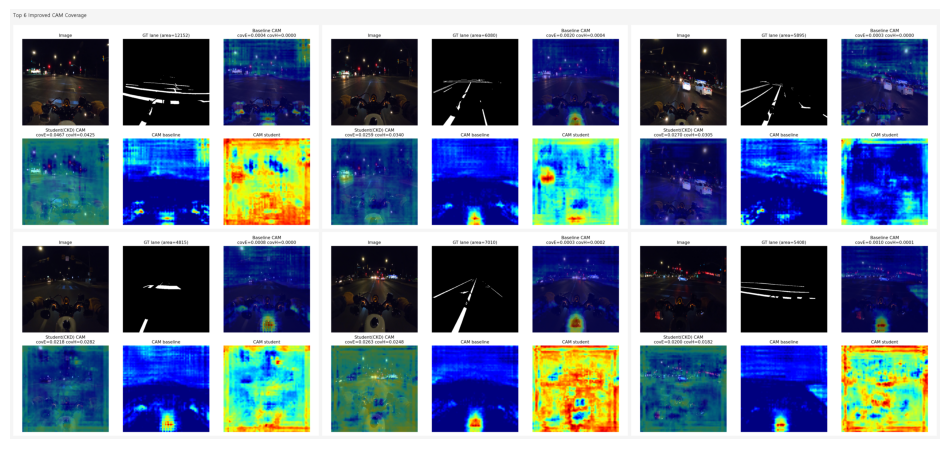

In [70]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\step9_cam_distilled\report_top6_improved.png")

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis("off")

### 이미지 해석 방법
-  report_top6_improved.png는 “Student(KD) CAM이 Baseline보다 GT Lane(흰 마스크)에 더 많이 걸린(top improved 6)” 사례만 모아 놓은 1장 요약
-  “전체 평균 성능” 그림이 아니라, 개선 사례 하이라이트
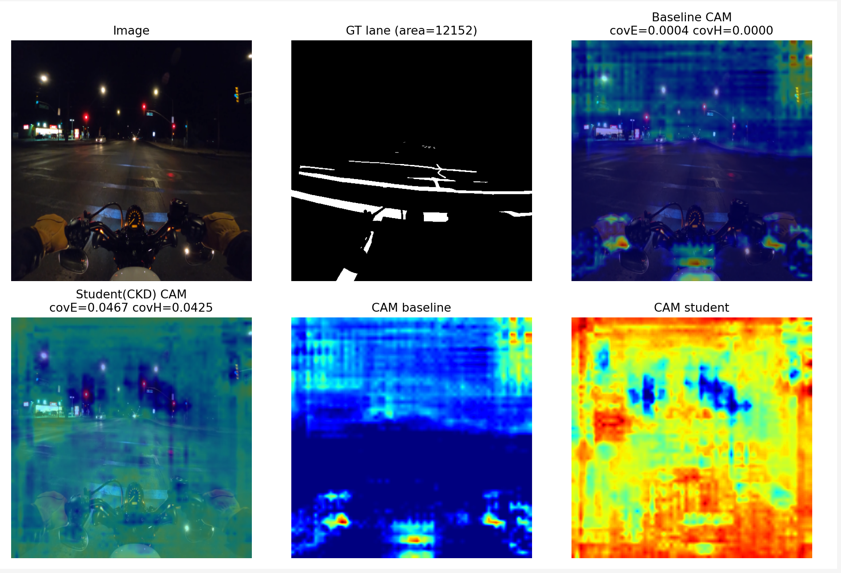
#### 1) 이 1장 그림의 6칸(각 샘플) 구조부터 정리

- 각 샘플은 2행×3열로 구성되어 있습니다.
- (1행 1열) Image: 원본 야간 주행 이미지
- (1행 2열) GT lane mask: GT(정답) Lane Mark 영역(흰색)
- (1행 3열) Baseline CAM: Baseline(DeepLab baseline) CAM을 이미지 위에 올린 것(overlay) + cov 지표가 제목에 표시됨
- (2행 1열) Student(KD) CAM: Distilled Student(DeepLab KD) CAM overlay + cov 지표
- (2행 2열) CAM baseline: Baseline CAM 원본 heatmap만
- (2행 3열) CAM student: Student CAM 원본 heatmap만
- 즉, 위(1행)는 “무엇을 봤는지(overlay)”, **아래(2행)는 “heatmap 자체 모양(노이즈/집중도)”**를 보라고 만든 구성